# Data Science Problem

We (Group 5: Bassa, Jen, Thomaz, Catherine) are public health researchers and have been tasked with identifying and understanding predictors of CVD in patient populations located in high-income countries.  Our employer, a group of medical professionals, is concerned with high CVD mortality among their patient population and seeks to identify better screening methods for CVD. Therefore, our goal is to identify the predictors most correlated with CVD; this will aid medical professionals in optimizing their CVD screening algorithms.

**Data Science Question:** Which predictors are associated with CVD?

---

### Data Sources Used
1. [Heart Statlog](https://www.kaggle.com/sid321axn/heart-statlog-cleveland-hungary-final)
1. [CHD](https://chronicdata.cdc.gov/500-Cities-Places/PLACES-Census-Tract-Data-GIS-Friendly-Format-2020-/yjkw-uj5s/data)

# Table of content
1. **Heart StatLog**
    1. [Cleaning and EDA](#eda)
    1. [Trying To Use Polynomial Transformations](#poly)
    1. [Comparing Poly Vs Normal ds](#basic_modeling)
    1. [Cleaning and Feature Engineering](#data_read_in)
    1. [Making a Function to Compare Different Cleaning Methods and Model Scores](#base_scores)
    1. [Combining Data to Get a Better Model Eval Score](#Combining_ideas)
    1. [Cleaning the Poly from previous step to get rid of some features](#tb_clean)
    1. [GridSearches](#gridsearches)
        1. [Logistic](#hlog)
        1. [Ada Boosting](#ada)
        1. [Gradient Boosting](#gb)
        1. [Random Forest](#rf)
        1. [Decision Tree](#dt)
        1. [SVC](#svc)
        1. [KNN](#hknn)
        1. [BNB](#hbnb)
        1. [NN](#nn)
        1. [Gradient Boost 2](#gd_boost2)
        1. [Voting Classifier](#voting)
        1. [Grid Search Scores](#gridsearch_scores)
    1. [Analysis Based off the Best Model](#hanalysis)
    1. [Conclusions & Recommendations](#hcnr)
1. **CHD Dataset**  
    1. [Data Dictionary](#jen)
    1. [Cleaning and Engineering](#jclean)
    1. **[Regression](#reg_eda)**
        1. [Regression Modeling](#reg_mod)
        1. [Linear Regression](#linear)
        1. [Ridge](#ridge)
        1. [Lasso](#lasso)
        1. [Regression Results](#reg_results)
        1. [Conclusions](#reg_conclusions)
    1. **[Classification](#classification)**
        1. [Cleaning/EDA & Engineering to be able to do a classification model](#cclean)
        1. [Classification Modeling](#cmodel)
        1. [Logistic Regression](#logreg)
        1. [KNN](#knn)
        1. [Bernuolli Naive Bayes](#bnb)
        1. [Conclusions](#class_con)
1. **[Next Steps](#nxtsteps)**
        

<img src ='./imgs/Data Dictionary.png'>

## Imports

In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm

from sklearn.linear_model import LogisticRegression, LinearRegression, RidgeCV, LassoCV
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score,  classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn import metrics
from sklearn.pipeline import Pipeline

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout

import timeit as ti

In [121]:
heart = pd.read_csv('/content/heart_statlog_cleveland_hungary_final (1).csv')
heart

,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
0,40,1,2,140,289,0,0,172,0,0.0,1,0
1,49,0,3,160,180,0,0,156,0,1.0,2,1
2,37,1,2,130,283,0,1,98,0,0.0,1,0
3,48,0,4,138,214,0,0,108,1,1.5,2,1
4,54,1,3,150,195,0,0,122,0,0.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1185,45,1,1,110,264,0,0,132,0,1.2,2,1
1186,68,1,4,144,193,1,0,141,0,3.4,2,1
1187,57,1,4,130,131,0,0,115,1,1.2,2,1
1188,57,0,2,130,236,0,2,174,0,0.0,2,1


# Cleaning and Data exploration <span id = 'eda'>
___

### Check for null values

In [122]:
heart.isnull().sum()

age                    0
sex                    0
chest pain type        0
resting bp s           0
cholesterol            0
fasting blood sugar    0
resting ecg            0
max heart rate         0
exercise angina        0
oldpeak                0
ST slope               0
target                 0
dtype: int64

In [123]:
heart.dtypes

age                      int64
sex                      int64
chest pain type          int64
resting bp s             int64
cholesterol              int64
fasting blood sugar      int64
resting ecg              int64
max heart rate           int64
exercise angina          int64
oldpeak                float64
ST slope                 int64
target                   int64
dtype: object

### Columns to make categorical instead of numeric
1. `chest pain type`
> Value 1: typical angina  
Value 2: atypical angina  
Value 3: non-anginal pain  
Value 4: asymptomatic

1. `resting ecg`
> Value 0: normal  
Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)  
Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria

1. `ST slope`
> Value 1: upsloping  
Value 2: flat  
Value 3: downsloping

In [124]:
heart['chest pain type'] = heart['chest pain type'].map({1:'TA', 2:'ATA', 3: 'NAP', 4:'Asympt' })
heart['resting ecg'] = heart['resting ecg'].map({0:'normal', 1:'ST-T abnormal', 2: 'lv hypertrophy'})
heart['ST slope'] = heart['ST slope'].map({1:'upsloping', 2:'flat', 3:'downslopping'})
heart.head(3)

,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
0,40,1,ATA,140,289,0,normal,172,0,0.0,upsloping,0
1,49,0,NAP,160,180,0,normal,156,0,1.0,flat,1
2,37,1,ATA,130,283,0,ST-T abnormal,98,0,0.0,upsloping,0


### Correlations of Numeric Values

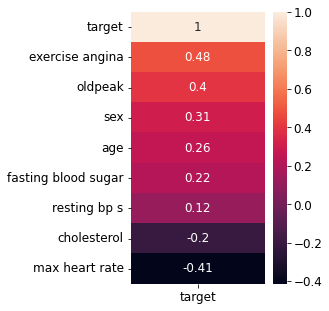

In [125]:
corr = heart.corr()

plt.figure(figsize = (3, 5))
sns.heatmap(corr[['target']].sort_values(by = 'target',ascending = False),
            annot = True)
# plt.savefig('./imgs/num_corr.png', dpi = 300, bbox_inches = 'tight')
plt.show()

**Observations**  
> 1. `cholesterol` has a lower correlation than we would expect. 
> 2. `max heart rate` has a strong negative correlation. Possibly because the faster the heart can pump the better it is?
> 3. It also appears that if `sex` is male, the more likely they are to have some heart disease

<span id='poly'></span>
## Testing polytransformations to see if we can get the correlations up a bit

In [126]:
# Lets choose specific columns first
numeric_features = heart._get_numeric_data().columns.drop('target')

poly = PolynomialFeatures(include_bias=False)
df = poly.fit_transform(heart[numeric_features])

# make it into a dateframe 
poly_df = pd.DataFrame(data = df, columns = poly.get_feature_names(numeric_features))
poly_df.head()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,age,sex,resting bp s,cholesterol,fasting blood sugar,max heart rate,exercise angina,oldpeak,age^2,age sex,age resting bp s,age cholesterol,age fasting blood sugar,age max heart rate,age exercise angina,age oldpeak,sex^2,sex resting bp s,sex cholesterol,sex fasting blood sugar,sex max heart rate,sex exercise angina,sex oldpeak,resting bp s^2,resting bp s cholesterol,resting bp s fasting blood sugar,resting bp s max heart rate,resting bp s exercise angina,resting bp s oldpeak,cholesterol^2,cholesterol fasting blood sugar,cholesterol max heart rate,cholesterol exercise angina,cholesterol oldpeak,fasting blood sugar^2,fasting blood sugar max heart rate,fasting blood sugar exercise angina,fasting blood sugar oldpeak,max heart rate^2,max heart rate exercise angina,max heart rate oldpeak,exercise angina^2,exercise angina oldpeak,oldpeak^2
0,40.0,1.0,140.0,289.0,0.0,172.0,0.0,0.0,1600.0,40.0,5600.0,11560.0,0.0,6880.0,0.0,0.0,1.0,140.0,289.0,0.0,172.0,0.0,0.0,19600.0,40460.0,0.0,24080.0,0.0,0.0,83521.0,0.0,49708.0,0.0,0.0,0.0,0.0,0.0,0.0,29584.0,0.0,0.0,0.0,0.0,0.00
1,49.0,0.0,160.0,180.0,0.0,156.0,0.0,1.0,2401.0,0.0,7840.0,8820.0,0.0,7644.0,0.0,49.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25600.0,28800.0,0.0,24960.0,0.0,160.0,32400.0,0.0,28080.0,0.0,180.0,0.0,0.0,0.0,0.0,24336.0,0.0,156.0,0.0,0.0,1.00
2,37.0,1.0,130.0,283.0,0.0,98.0,0.0,0.0,1369.0,37.0,4810.0,10471.0,0.0,3626.0,0.0,0.0,1.0,130.0,283.0,0.0,98.0,0.0,0.0,16900.0,36790.0,0.0,12740.0,0.0,0.0,80089.0,0.0,27734.0,0.0,0.0,0.0,0.0,0.0,0.0,9604.0,0.0,0.0,0.0,0.0,0.00
3,48.0,0.0,138.0,214.0,0.0,108.0,1.0,1.5,2304.0,0.0,6624.0,10272.0,0.0,5184.0,48.0,72.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19044.0,29532.0,0.0,14904.0,138.0,207.0,45796.0,0.0,23112.0,214.0,321.0,0.0,0.0,0.0,0.0,11664.0,108.0,162.0,1.0,1.5,2.25
4,54.0,1.0,150.0,195.0,0.0,122.0,0.0,0.0,2916.0,54.0,8100.0,10530.0,0.0,6588.0,0.0,0.0,1.0,150.0,195.0,0.0,122.0,0.0,0.0,22500.0,29250.0,0.0,18300.0,0.0,0.0,38025.0,0.0,23790.0,0.0,0.0,0.0,0.0,0.0,0.0,14884.0,0.0,0.0,0.0,0.0,0.00


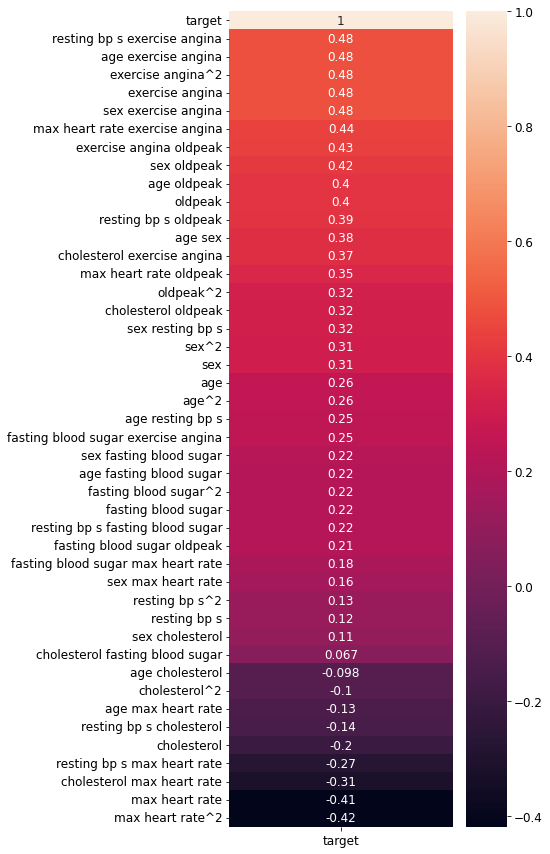

In [127]:
# add in our target so we can check correlation
poly_df['target'] = heart['target']

# Check our new correlation
corr = poly_df.corr()

plt.figure(figsize = (5, 15))
sns.heatmap(corr[['target']].sort_values(by = 'target',ascending = False),
            annot = True)
plt.show()

**Observation**  
> It does appear that doing the poly fit has helped. Will run a cross_val_score check as a baseline on both to check though

<span id ='basic_modeling'></span>
## Splitting the Data for both the heart and poly_df

In [128]:
# only using numeric features how much the polytrans will affect scores without the categorical columns
X_heart = heart[numeric_features]
X_poly = poly_df.drop('target', axis = 1)
y = heart['target']

X_heart_train, X_heart_test, y_train, y_test = train_test_split(X_heart, y, stratify=y, random_state= 1996)
X_poly_train, X_poly_test, y_train, y_test = train_test_split(X_poly, y, stratify=y, random_state= 1996)

In [129]:
# Scaling the data for only the trains since we aren't looking at test rn
sc = StandardScaler()
X_heart_train = sc.fit_transform(X_heart_train)
X_poly_train = sc.fit_transform(X_poly_train)

In [130]:
print(cross_val_score(LogisticRegression(max_iter=10_000), X_heart_train, y_train, cv = 5).mean())
print(cross_val_score(LogisticRegression(max_iter=10_000), X_poly_train, y_train, cv = 5).mean())

0.7992781369656645
0.8127550059632164


**Observation**
> The polytransforming does seem to help a bit, but only by 2%, however keep in mind that this is without the categorical columns as well as no gridsearch, out final score might be even higher

In [131]:
cat_col = list(set(heart.columns) - set(numeric_features))
cat_col.remove('target')
cat_col

['ST slope', 'chest pain type', 'resting ecg']

In [132]:
# Lets make these columns into dummies to append to the X_poly df
dummy_df = pd.get_dummies(data = heart[cat_col], drop_first=True)
dummy_df.head()

,ST slope_flat,ST slope_upsloping,chest pain type_Asympt,chest pain type_NAP,chest pain type_TA,resting ecg_lv hypertrophy,resting ecg_normal
0,0,1,0,0,0,0,1
1,1,0,0,1,0,0,1
2,0,1,0,0,0,0,0
3,1,0,1,0,0,0,1
4,0,1,0,1,0,0,1


In [133]:
## add the dummy to X_poly
X_poly_dummy = X_poly.join(dummy_df)
X_poly_dummy.head()

,age,sex,resting bp s,cholesterol,fasting blood sugar,max heart rate,exercise angina,oldpeak,age^2,age sex,age resting bp s,age cholesterol,age fasting blood sugar,age max heart rate,age exercise angina,age oldpeak,sex^2,sex resting bp s,sex cholesterol,sex fasting blood sugar,sex max heart rate,sex exercise angina,sex oldpeak,resting bp s^2,resting bp s cholesterol,resting bp s fasting blood sugar,resting bp s max heart rate,resting bp s exercise angina,resting bp s oldpeak,cholesterol^2,cholesterol fasting blood sugar,cholesterol max heart rate,cholesterol exercise angina,cholesterol oldpeak,fasting blood sugar^2,fasting blood sugar max heart rate,fasting blood sugar exercise angina,fasting blood sugar oldpeak,max heart rate^2,max heart rate exercise angina,max heart rate oldpeak,exercise angina^2,exercise angina oldpeak,oldpeak^2,ST slope_flat,ST slope_upsloping,chest pain type_Asympt,chest pain type_NAP,chest pain type_TA,resting ecg_lv hypertrophy,resting ecg_normal
0,40.0,1.0,140.0,289.0,0.0,172.0,0.0,0.0,1600.0,40.0,5600.0,11560.0,0.0,6880.0,0.0,0.0,1.0,140.0,289.0,0.0,172.0,0.0,0.0,19600.0,40460.0,0.0,24080.0,0.0,0.0,83521.0,0.0,49708.0,0.0,0.0,0.0,0.0,0.0,0.0,29584.0,0.0,0.0,0.0,0.0,0.00,0,1,0,0,0,0,1
1,49.0,0.0,160.0,180.0,0.0,156.0,0.0,1.0,2401.0,0.0,7840.0,8820.0,0.0,7644.0,0.0,49.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25600.0,28800.0,0.0,24960.0,0.0,160.0,32400.0,0.0,28080.0,0.0,180.0,0.0,0.0,0.0,0.0,24336.0,0.0,156.0,0.0,0.0,1.00,1,0,0,1,0,0,1
2,37.0,1.0,130.0,283.0,0.0,98.0,0.0,0.0,1369.0,37.0,4810.0,10471.0,0.0,3626.0,0.0,0.0,1.0,130.0,283.0,0.0,98.0,0.0,0.0,16900.0,36790.0,0.0,12740.0,0.0,0.0,80089.0,0.0,27734.0,0.0,0.0,0.0,0.0,0.0,0.0,9604.0,0.0,0.0,0.0,0.0,0.00,0,1,0,0,0,0,0
3,48.0,0.0,138.0,214.0,0.0,108.0,1.0,1.5,2304.0,0.0,6624.0,10272.0,0.0,5184.0,48.0,72.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19044.0,29532.0,0.0,14904.0,138.0,207.0,45796.0,0.0,23112.0,214.0,321.0,0.0,0.0,0.0,0.0,11664.0,108.0,162.0,1.0,1.5,2.25,1,0,1,0,0,0,1
4,54.0,1.0,150.0,195.0,0.0,122.0,0.0,0.0,2916.0,54.0,8100.0,10530.0,0.0,6588.0,0.0,0.0,1.0,150.0,195.0,0.0,122.0,0.0,0.0,22500.0,29250.0,0.0,18300.0,0.0,0.0,38025.0,0.0,23790.0,0.0,0.0,0.0,0.0,0.0,0.0,14884.0,0.0,0.0,0.0,0.0,0.00,0,1,0,1,0,0,1


In [134]:
# One last check score check with the original df vs poly with all columns now
# Make the dummy_df full
heart_dummy = pd.get_dummies(data = heart, columns=cat_col)
heart_dummy.head(3)

,age,sex,resting bp s,cholesterol,fasting blood sugar,max heart rate,exercise angina,oldpeak,target,ST slope_downslopping,ST slope_flat,ST slope_upsloping,chest pain type_ATA,chest pain type_Asympt,chest pain type_NAP,chest pain type_TA,resting ecg_ST-T abnormal,resting ecg_lv hypertrophy,resting ecg_normal
0,40,1,140,289,0,172,0,0.0,0,0,0,1,1,0,0,0,0,0,1
1,49,0,160,180,0,156,0,1.0,1,0,1,0,0,0,1,0,0,0,1
2,37,1,130,283,0,98,0,0.0,0,0,0,1,1,0,0,0,1,0,0


In [135]:
# make a new X since the target is still here
X_heart = heart_dummy.drop('target', axis = 1)

X_heart_train, X_heart_test, y_train, y_test = train_test_split(X_heart, y, stratify=y, random_state= 1996)
X_poly_train, X_poly_test, y_train, y_test = train_test_split(X_poly, y, stratify=y, random_state= 1996)

In [136]:
sc = StandardScaler()
X_heart_train = sc.fit_transform(X_heart_train)
X_poly_train = sc.fit_transform(X_poly_train)

In [137]:
print(cross_val_score(LogisticRegression(max_iter=20_000, tol = 0.1), X_heart_train, y_train, cv = 5).mean())
print(cross_val_score(LogisticRegression(max_iter=20_000, tol = 0.1,), X_poly_train, y_train, cv = 5).mean())

0.8509384219446362
0.8127550059632164


**Observation**
> While both the testing set averages went up, the difference between the two is now only around 0.4%. We would still like to go forward with the poly set though. It is a a bit better and we can try getting rid of some columns and keeping what has a higher coef

# Set up Data Version 2 <span id='data_read_in'>

### Reading in the data

In [138]:
hrt_dt = pd.read_csv('/content/heart_statlog_cleveland_hungary_final (1).csv')

### Feature Engineering

In [139]:
hrt_dt["ST slope_sqr"] = hrt_dt["ST slope"]**2
hrt_dt["chest pain type_sqr"]  = hrt_dt["chest pain type"]**2
hrt_dt["ST slope*chest pain type"] = hrt_dt["ST slope"]*hrt_dt["chest pain type"] 
hrt_dt["ST slope*cholesterol"] = hrt_dt["cholesterol"]*hrt_dt["ST slope"]
hrt_dt["cholesterol*max heart rate"] = hrt_dt["max heart rate"]*hrt_dt["cholesterol"]

<span id = 'base_scores'></span>
## Making a function to return multiple test results (No hyperparameters) in a DF

In [140]:
base_df = pd.DataFrame(columns=['Notes','Log_train', 'Log_test','Bag_train', 'Bag_test',
                                'Ada_boost_train', 'Ada_boost_test','Grad_train',
                                'Grad_test','RF_train','RF_test',
                                'SVC_train','SVC_test', 'KNN_train', 'KNN_test'])
base_df

,Notes,Log_train,Log_test,Bag_train,Bag_test,Ada_boost_train,Ada_boost_test,Grad_train,Grad_test,RF_train,RF_test,SVC_train,SVC_test,KNN_train,KNN_test


In [141]:
# purpose to get number of different test accuracy quickly to see if getting rid of features help or not beore testing
def base_scores(X, y, note):
    # Set up general train test splits
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y,test_size = 0.3, random_state =22)
    ss = StandardScaler()
    X_train_ss = ss.fit_transform(X_train)
    X_test_ss = ss.transform(X_test)
    
    # Results for Logistic Regression
    log_model = LogisticRegression(max_iter=2_000)
    log_model.fit(X_train_ss, y_train)
    log_train = log_model.score(X_train_ss, y_train)
    log_test = log_model.score(X_test_ss, y_test)

    
    # Results for Bagging
    bag = BaggingClassifier(random_state=42)
    bag.fit(X_train, y_train)
    bag_train = bag.score(X_train, y_train)
    bag_test = bag.score(X_test, y_test)

    
    # Ada Boosting no base estimator
    adabost = AdaBoostClassifier(base_estimator=RandomForestClassifier(max_depth=2))
    adabost.fit(X_train, y_train)
    ada_train = adabost.score(X_train, y_train)
    ada_test = adabost.score(X_test, y_test)

    
    # Gradient Boosting
    base_gbost = GradientBoostingClassifier()
    base_gbost.fit(X_train, y_train)
    base_gb_train = base_gbost.score(X_train, y_train)
    base_gb_test = base_gbost.score(X_test, y_test)

    
    # RandomForest
    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)
    rf_train = rf.score(X_train, y_train)
    rf_test = rf.score(X_test, y_test)
    
    
    # SVM
    svc = SVC()
    svc.fit(X_train_ss, y_train)
    svc_train = svc.score(X_train_ss, y_train)
    svc_test = svc.score(X_test_ss, y_test)

    
    # KNN
    knn = KNeighborsClassifier()
    knn.fit(X_train_ss, y_train)
    knn_train = knn.score(X_train_ss, y_train)
    knn_test = knn.score(X_test_ss, y_test)
    
    
    # adding all the information to a dataframe
    info_list = []
    d = {}
    d['Notes'] = note
    d['Log_train'] = log_train
    d['Log_test'] = log_test
    d['Bag_train'] = bag_train
    d['Bag_test'] = bag_test
    d['Ada_boost_train'] = ada_train
    d['Ada_boost_test'] = ada_test
    d['Grad_train'] = base_gb_train
    d['Grad_test'] = base_gb_test
    d['RF_train'] = rf_train
    d['RF_test'] = rf_test
    d['SVC_train'] = svc_train
    d['SVC_test'] = svc_test
    d['KNN_train'] = knn_train
    d['KNN_test'] = knn_test
    
    # appending all this information to a list to add to the dataframe base_df
    info_list.append(d)
    return base_df.append(info_list)

In [142]:
def graph_scores(X, y):
    # Set up general train test splits
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y,test_size = 0.3, random_state =22)
    ss = StandardScaler()
    X_train_ss = ss.fit_transform(X_train)
    X_test_ss = ss.transform(X_test)
  
    testing_accuracy_dict = {}
    # Results for Logistic Regression
    log_model = LogisticRegression(max_iter=2000)
    log_model.fit(X_train_ss, y_train)

    testing_accuracy_dict["log_model"] = []
    testing_accuracy_dict["log_model"].append(log_model.score(X_train_ss, y_train))
    testing_accuracy_dict["log_model"].append(log_model.score(X_test_ss, y_test))
     
    # Results for Bagging
    bag_modle = BaggingClassifier(random_state=42)
    bag_modle.fit(X_train, y_train)

    testing_accuracy_dict["bag_model"] = []
    testing_accuracy_dict["bag_model"].append(bag_modle.score(X_train, y_train))
    testing_accuracy_dict["bag_model"].append(bag_modle.score(X_test, y_test))
    # Ada Boosting no base estimator
    adabost = AdaBoostClassifier(base_estimator=RandomForestClassifier(max_depth=2))
    adabost.fit(X_train, y_train)

    # Gradient Boosting
    base_gbost = GradientBoostingClassifier()
    base_gbost.fit(X_train, y_train)

    testing_accuracy_dict["base_gbost"] = []
    testing_accuracy_dict["base_gbost"].append(base_gbost.score(X_train, y_train))
    testing_accuracy_dict["base_gbost"].append(base_gbost.score(X_test, y_test))
    
    # RandomForest
    rf_model = RandomForestClassifier()
    rf_model.fit(X_train, y_train)

    
    testing_accuracy_dict["rf_model"] = []
    testing_accuracy_dict["rf_model"].append(rf_model.score(X_train, y_train))
    testing_accuracy_dict["rf_model"].append(rf_model.score(X_test, y_test))
    
    
    # SVM
    svc_model = SVC()
    svc_model.fit(X_train_ss, y_train)

    
    testing_accuracy_dict["svc_model"] = []
    testing_accuracy_dict["svc_model"].append(svc_model.score(X_train, y_train))
    testing_accuracy_dict["svc_model"].append(svc_model.score(X_test, y_test))
    
    # KNN
    knn_model = KNeighborsClassifier()
    knn_model.fit(X_train_ss, y_train)

    testing_accuracy_dict["knn_model"] = []
    testing_accuracy_dict["knn_model"].append(knn_model.score(X_train, y_train))
    testing_accuracy_dict["knn_model"].append(knn_model.score(X_test, y_test))
    
    return testing_accuracy_dict

In [143]:
X_data = hrt_dt.drop("target", axis = 1)
X_heart = heart[numeric_features] # numeric features only
X_heart_dummy = heart_dummy.drop('target', axis = 1)
X_poly = poly_df.drop('target', axis = 1)
X_poly_dummy = X_poly_dummy

y = heart['target']

In [144]:
base_df = base_scores(X_data, y, "DF data")
base_df = base_scores(X_heart, y, "Heart Numeric Only")
base_df = base_scores(X_heart_dummy, y, "Heart w/ dummy")
base_df = base_scores(X_poly, y, "Poly numeric only")
base_df = base_scores(X_poly_dummy, y, "Poly with dummy")

base_df

,Notes,Log_train,Log_test,Bag_train,Bag_test,Ada_boost_train,Ada_boost_test,Grad_train,Grad_test,RF_train,RF_test,SVC_train,SVC_test,KNN_train,KNN_test
0,DF data,0.847539,0.837535,0.996399,0.910364,0.965186,0.885154,0.954382,0.904762,1.0,0.915966,0.901561,0.871148,0.899160,0.862745
0,Heart Numeric Only,0.805522,0.817927,0.986795,0.817927,0.912365,0.823529,0.913565,0.831933,1.0,0.865546,0.852341,0.831933,0.843938,0.817927
0,Heart w/ dummy,0.860744,0.840336,0.992797,0.901961,0.959184,0.873950,0.955582,0.893557,1.0,0.921569,0.908764,0.868347,0.884754,0.854342
0,Poly numeric only,0.818727,0.826331,0.992797,0.848739,0.960384,0.848739,0.948379,0.820728,1.0,0.859944,0.842737,0.823529,0.836735,0.815126
0,Poly with dummy,0.863145,0.848739,0.991597,0.896359,0.985594,0.896359,0.977191,0.901961,1.0,0.918768,0.897959,0.871148,0.895558,0.834734


In [145]:
base_df.reset_index(inplace=True)
base_df.drop('index', axis = 1, inplace = True)
base_df.head()

,Notes,Log_train,Log_test,Bag_train,Bag_test,Ada_boost_train,Ada_boost_test,Grad_train,Grad_test,RF_train,RF_test,SVC_train,SVC_test,KNN_train,KNN_test
0,DF data,0.847539,0.837535,0.996399,0.910364,0.965186,0.885154,0.954382,0.904762,1.0,0.915966,0.901561,0.871148,0.899160,0.862745
1,Heart Numeric Only,0.805522,0.817927,0.986795,0.817927,0.912365,0.823529,0.913565,0.831933,1.0,0.865546,0.852341,0.831933,0.843938,0.817927
2,Heart w/ dummy,0.860744,0.840336,0.992797,0.901961,0.959184,0.873950,0.955582,0.893557,1.0,0.921569,0.908764,0.868347,0.884754,0.854342
3,Poly numeric only,0.818727,0.826331,0.992797,0.848739,0.960384,0.848739,0.948379,0.820728,1.0,0.859944,0.842737,0.823529,0.836735,0.815126
4,Poly with dummy,0.863145,0.848739,0.991597,0.896359,0.985594,0.896359,0.977191,0.901961,1.0,0.918768,0.897959,0.871148,0.895558,0.834734


In [146]:
sum(base_df.loc[0,['Log_test','Bag_test','Ada_boost_test',
                            'Grad_test','RF_test','SVC_test', 'KNN_test']] > base_df.loc[4,['Log_test','Bag_test','Ada_boost_test','Grad_test','RF_test','SVC_test', 'KNN_test']])

3

> Out of 7 columns, so 7 different test, the second version's cleaned data did better than the Polyfit with the dummy 3 times, and tied once. One thing to note is that second version data has 35 fewer columns and therefore more efficent in find the the important features and combinations  

> One idea coming to mind right now would be to keep the data as is (without making it into categorical columns and just doing a polyfit

<span id ='Combining_ideas'></span>
## Combining Data & Ideas

In [147]:
heart_3 = pd.read_csv('/content/heart_statlog_cleveland_hungary_final (1).csv')

In [148]:
# Changing name from `resting bp s` to resting SBP`
heart_3.rename(columns={'resting bp s': 'resting SBP'}, inplace = True)

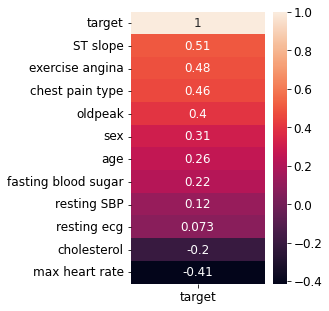

In [149]:
corr = heart_3.corr()

plt.figure(figsize = (3, 5))
sns.heatmap(corr[['target']].sort_values(by = 'target',ascending = False),
            annot = True)

plt.show()

In [150]:
# Lets choose specific columns first
numeric_features_2 = heart_3.drop('target', axis = 1).columns

poly_2 = PolynomialFeatures(include_bias=False)
df_2 = poly_2.fit_transform(heart_3[numeric_features_2])

# make it into a dateframe 
poly_df_2 = pd.DataFrame(data = df_2, columns = poly_2.get_feature_names(numeric_features_2))
poly_df_2.head()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,age,sex,chest pain type,resting SBP,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,age^2,age sex,age chest pain type,age resting SBP,age cholesterol,age fasting blood sugar,age resting ecg,age max heart rate,age exercise angina,age oldpeak,age ST slope,sex^2,sex chest pain type,sex resting SBP,sex cholesterol,sex fasting blood sugar,sex resting ecg,sex max heart rate,sex exercise angina,sex oldpeak,sex ST slope,chest pain type^2,chest pain type resting SBP,chest pain type cholesterol,chest pain type fasting blood sugar,chest pain type resting ecg,chest pain type max heart rate,chest pain type exercise angina,chest pain type oldpeak,chest pain type ST slope,resting SBP^2,resting SBP cholesterol,resting SBP fasting blood sugar,resting SBP resting ecg,resting SBP max heart rate,resting SBP exercise angina,resting SBP oldpeak,resting SBP ST slope,cholesterol^2,cholesterol fasting blood sugar,cholesterol resting ecg,cholesterol max heart rate,cholesterol exercise angina,cholesterol oldpeak,cholesterol ST slope,fasting blood sugar^2,fasting blood sugar resting ecg,fasting blood sugar max heart rate,fasting blood sugar exercise angina,fasting blood sugar oldpeak,fasting blood sugar ST slope,resting ecg^2,resting ecg max heart rate,resting ecg exercise angina,resting ecg oldpeak,resting ecg ST slope,max heart rate^2,max heart rate exercise angina,max heart rate oldpeak,max heart rate ST slope,exercise angina^2,exercise angina oldpeak,exercise angina ST slope,oldpeak^2,oldpeak ST slope,ST slope^2
0,40.0,1.0,2.0,140.0,289.0,0.0,0.0,172.0,0.0,0.0,1.0,1600.0,40.0,80.0,5600.0,11560.0,0.0,0.0,6880.0,0.0,0.0,40.0,1.0,2.0,140.0,289.0,0.0,0.0,172.0,0.0,0.0,1.0,4.0,280.0,578.0,0.0,0.0,344.0,0.0,0.0,2.0,19600.0,40460.0,0.0,0.0,24080.0,0.0,0.0,140.0,83521.0,0.0,0.0,49708.0,0.0,0.0,289.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29584.0,0.0,0.0,172.0,0.0,0.0,0.0,0.00,0.0,1.0
1,49.0,0.0,3.0,160.0,180.0,0.0,0.0,156.0,0.0,1.0,2.0,2401.0,0.0,147.0,7840.0,8820.0,0.0,0.0,7644.0,0.0,49.0,98.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,480.0,540.0,0.0,0.0,468.0,0.0,3.0,6.0,25600.0,28800.0,0.0,0.0,24960.0,0.0,160.0,320.0,32400.0,0.0,0.0,28080.0,0.0,180.0,360.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24336.0,0.0,156.0,312.0,0.0,0.0,0.0,1.00,2.0,4.0
2,37.0,1.0,2.0,130.0,283.0,0.0,1.0,98.0,0.0,0.0,1.0,1369.0,37.0,74.0,4810.0,10471.0,0.0,37.0,3626.0,0.0,0.0,37.0,1.0,2.0,130.0,283.0,0.0,1.0,98.0,0.0,0.0,1.0,4.0,260.0,566.0,0.0,2.0,196.0,0.0,0.0,2.0,16900.0,36790.0,0.0,130.0,12740.0,0.0,0.0,130.0,80089.0,0.0,283.0,27734.0,0.0,0.0,283.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,98.0,0.0,0.0,1.0,9604.0,0.0,0.0,98.0,0.0,0.0,0.0,0.00,0.0,1.0
3,48.0,0.0,4.0,138.0,214.0,0.0,0.0,108.0,1.0,1.5,2.0,2304.0,0.0,192.0,6624.0,10272.0,0.0,0.0,5184.0,48.0,72.0,96.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,552.0,856.0,0.0,0.0,432.0,4.0,6.0,8.0,19044.0,29532.0,0.0,0.0,14904.0,138.0,207.0,276.0,45796.0,0.0,0.0,23112.0,214.0,321.0,428.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11664.0,108.0,162.0,216.0,1.0,1.5,2.0,2.25,3.0,4.0
4,54.0,1.0,3.0,150.0,195.0,0.0,0.0,122.0,0.0,0.0,1.0,2916.0,54.0,162.0,8100.0,10530.0,0.0,0.0,6588.0,0.0,0.0,54.0,1.0,3.0,150.0,195.0,0.0,0.0,122.0,0.0,0.0,1.0,9.0,450.0,585.0,0.0,0.0,366.0,0.0,0.0,3.0,22500.0,29250.0,0.0,0.0,18300.0,0.0,0.0,150.0,38025.0,0.0,0.0,23790.0,0.0,0.0,195.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14884.0,0.0,0.0,122.0,0.0,0.0,0.0,0.00,0.0,1.0


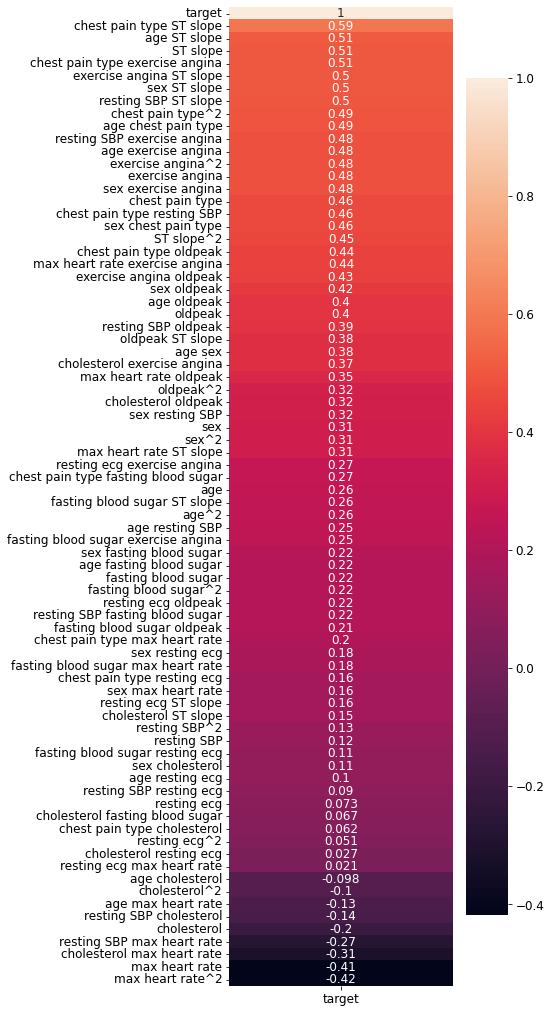

In [151]:
# adding in the target variable to get a corralation
poly_df_2['target'] = y
corr = poly_df_2.corr()

plt.figure(figsize = (5, 18))
sns.heatmap(corr[['target']].sort_values(by = 'target',ascending = False),
            annot = True)

plt.show()

In [152]:
X_poly_2 = poly_df_2.drop('target', axis =1)
base_df = base_scores(X_poly_2, y, "Combined Poly idea")

base_df

,Notes,Log_train,Log_test,Bag_train,Bag_test,Ada_boost_train,Ada_boost_test,Grad_train,Grad_test,RF_train,RF_test,SVC_train,SVC_test,KNN_train,KNN_test
0,DF data,0.847539,0.837535,0.996399,0.910364,0.965186,0.885154,0.954382,0.904762,1.0,0.915966,0.901561,0.871148,0.899160,0.862745
1,Heart Numeric Only,0.805522,0.817927,0.986795,0.817927,0.912365,0.823529,0.913565,0.831933,1.0,0.865546,0.852341,0.831933,0.843938,0.817927
2,Heart w/ dummy,0.860744,0.840336,0.992797,0.901961,0.959184,0.873950,0.955582,0.893557,1.0,0.921569,0.908764,0.868347,0.884754,0.854342
3,Poly numeric only,0.818727,0.826331,0.992797,0.848739,0.960384,0.848739,0.948379,0.820728,1.0,0.859944,0.842737,0.823529,0.836735,0.815126
4,Poly with dummy,0.863145,0.848739,0.991597,0.896359,0.985594,0.896359,0.977191,0.901961,1.0,0.918768,0.897959,0.871148,0.895558,0.834734
0,Combined Poly idea,0.870348,0.865546,0.995198,0.893557,0.986795,0.907563,0.979592,0.910364,1.0,0.915966,0.896759,0.873950,0.883553,0.843137


In [153]:
base_df.reset_index(inplace=True)
base_df.drop('index', axis = 1, inplace = True)
base_df

,Notes,Log_train,Log_test,Bag_train,Bag_test,Ada_boost_train,Ada_boost_test,Grad_train,Grad_test,RF_train,RF_test,SVC_train,SVC_test,KNN_train,KNN_test
0,DF data,0.847539,0.837535,0.996399,0.910364,0.965186,0.885154,0.954382,0.904762,1.0,0.915966,0.901561,0.871148,0.899160,0.862745
1,Heart Numeric Only,0.805522,0.817927,0.986795,0.817927,0.912365,0.823529,0.913565,0.831933,1.0,0.865546,0.852341,0.831933,0.843938,0.817927
2,Heart w/ dummy,0.860744,0.840336,0.992797,0.901961,0.959184,0.873950,0.955582,0.893557,1.0,0.921569,0.908764,0.868347,0.884754,0.854342
3,Poly numeric only,0.818727,0.826331,0.992797,0.848739,0.960384,0.848739,0.948379,0.820728,1.0,0.859944,0.842737,0.823529,0.836735,0.815126
4,Poly with dummy,0.863145,0.848739,0.991597,0.896359,0.985594,0.896359,0.977191,0.901961,1.0,0.918768,0.897959,0.871148,0.895558,0.834734
5,Combined Poly idea,0.870348,0.865546,0.995198,0.893557,0.986795,0.907563,0.979592,0.910364,1.0,0.915966,0.896759,0.873950,0.883553,0.843137


In [154]:
sum(base_df.loc[0,['Log_test','Bag_test','Ada_boost_test',
                            'Grad_test','RF_test','SVC_test', 'KNN_test']] < base_df.loc[5,['Log_test','Bag_test','Ada_boost_test','Grad_test','RF_test','SVC_test', 'KNN_test']])

4

> Combing ideas, we managed to get a model that did better in 5/7 tests, so this will be the dataset we will work from

<span id = 'tb_clean'></span>

---


## Getting rid of some columns from Combined_poly

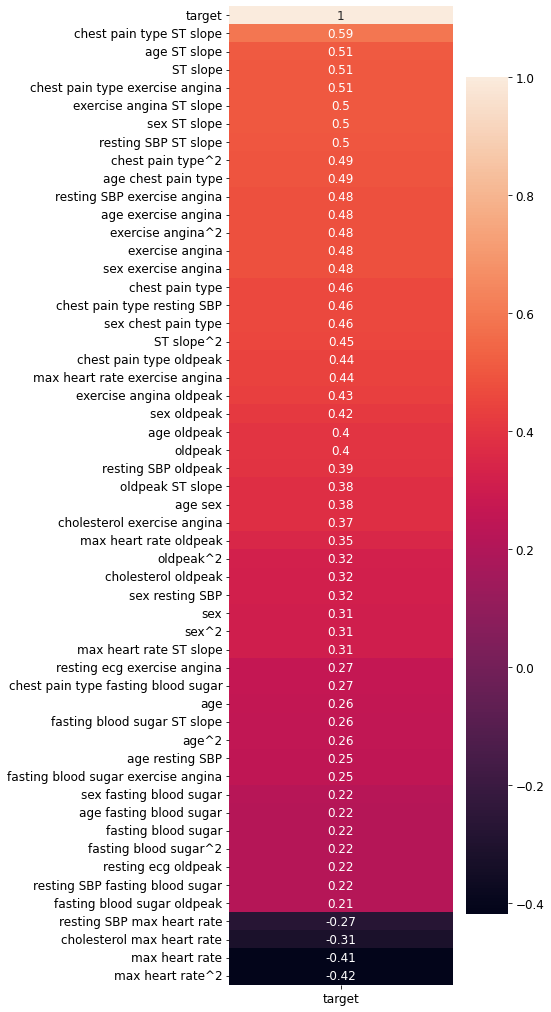

In [155]:
# Adding in the target variable to get a corralation
corr = poly_df_2.corr()[['target']]
corr = corr.loc[(corr['target'] > .2) | (corr['target'] < -0.2)]

plt.figure(figsize = (5, 18))
sns.heatmap(corr[['target']].sort_values(by = 'target',ascending = False),
            annot = True)
plt.show()

In [156]:
poly_3 = poly_df_2[list(corr.index)]
X_poly_3 = poly_3.drop('target', axis = 1)

In [157]:
base_df = base_scores(X_poly_3, y, "Got rid of low corr")
base_df.reset_index(inplace=True)
base_df.drop('index', axis = 1, inplace = True)
base_df

,Notes,Log_train,Log_test,Bag_train,Bag_test,Ada_boost_train,Ada_boost_test,Grad_train,Grad_test,RF_train,RF_test,SVC_train,SVC_test,KNN_train,KNN_test
0,DF data,0.847539,0.837535,0.996399,0.910364,0.965186,0.885154,0.954382,0.904762,1.0,0.915966,0.901561,0.871148,0.899160,0.862745
1,Heart Numeric Only,0.805522,0.817927,0.986795,0.817927,0.912365,0.823529,0.913565,0.831933,1.0,0.865546,0.852341,0.831933,0.843938,0.817927
2,Heart w/ dummy,0.860744,0.840336,0.992797,0.901961,0.959184,0.873950,0.955582,0.893557,1.0,0.921569,0.908764,0.868347,0.884754,0.854342
3,Poly numeric only,0.818727,0.826331,0.992797,0.848739,0.960384,0.848739,0.948379,0.820728,1.0,0.859944,0.842737,0.823529,0.836735,0.815126
4,Poly with dummy,0.863145,0.848739,0.991597,0.896359,0.985594,0.896359,0.977191,0.901961,1.0,0.918768,0.897959,0.871148,0.895558,0.834734
5,Combined Poly idea,0.870348,0.865546,0.995198,0.893557,0.986795,0.907563,0.979592,0.910364,1.0,0.915966,0.896759,0.873950,0.883553,0.843137
6,Got rid of low corr,0.857143,0.868347,0.992797,0.899160,0.986795,0.907563,0.978391,0.904762,1.0,0.910364,0.876351,0.868347,0.890756,0.840336


In [158]:
sum(base_df.loc[6,['Log_test','Bag_test','Ada_boost_test',
                            'Grad_test','RF_test','SVC_test', 'KNN_test']] > base_df.loc[5,['Log_test','Bag_test','Ada_boost_test','Grad_test','RF_test','SVC_test', 'KNN_test']])

2

> By getting rid of some 20-ish rows, the new dataframe is now tied with the full combined_poly. 3 wins and 1 tie

## Visual Representation of Accuracy of the Top 2 Datasets

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SVC was fitted without featu

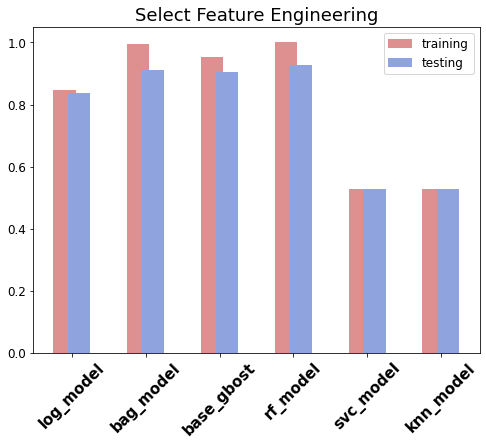

In [159]:
keys = [key for key in graph_scores(X_data, y).keys()]
values = [value for value in graph_scores(X_data, y).values()]
fig, ax = plt.subplots(figsize = (8, 6))
ax.bar(np.arange(len(keys)) - 0.1, [value[0] for value in values],
       width=0.3, color='#DE8F8F', align='center', label = "training")
ax.bar(np.arange(len(keys)) + 0.1,
       [value[1] if len(value) == 2 else 0 for value in values],
       width=0.3, color='#8FA3DE', align='center',  label = "testing")
ax.set_xticks(np.arange(len(keys)))
ax.set_xticklabels(keys, rotation=45,  fontsize = 15,
                   fontweight = "bold")
plt.legend(fontsize = 12)
plt.title('Select Feature Engineering', size = 18)
# plt.savefig('./imgs/sfe_models.png',dpi=300, bbox_inches = "tight")

plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SVC was fitted without featu

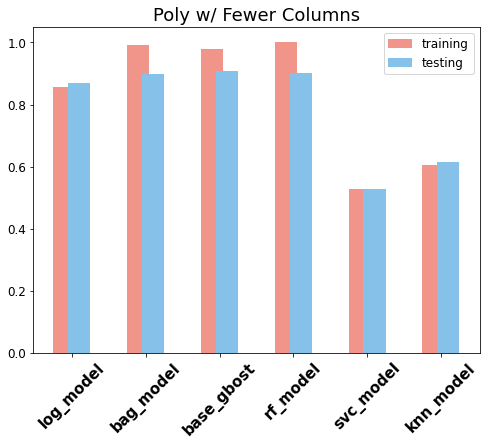

In [160]:
keys = [key for key in graph_scores(X_poly_3, y).keys()]
values = [value for value in graph_scores(X_poly_3, y).values()]
fig, ax = plt.subplots(figsize = (8, 6))
ax.bar(np.arange(len(keys)) - 0.1, [value[0] for value in values],
       width=0.3, color='#F1948A', align='center', label = "training")
ax.bar(np.arange(len(keys)) + 0.1,
       [value[1] if len(value) == 2 else 0 for value in values],
       width=0.3, color='#85C1E9', align='center',  label = "testing")
ax.set_xticks(np.arange(len(keys)))
ax.set_xticklabels(keys, rotation=45,  fontsize = 15,
                   fontweight = "bold")
plt.legend(fontsize = 12)
plt.title('Poly w/ Fewer Columns', size = 18)
# plt.savefig('./imgs/pwfc_models.png',dpi=300, bbox_inches = "tight")
plt.show()

<span id = 'gridsearches'></span>
## Time to start looking at some GridSearches
> Using the poly_3 because it has fewer columns and did well on some tests, and will hopefully let the models run a bit faster

### Basic Function to print out the Recall, Precision, and Accuracy

In [161]:
## This will just be a function to return the recall, precision, accuracy
def arp(model, X, y,):
    preds = model.predict(X)
    
    scores = {}
    scores['Recall']  = metrics.recall_score(y, preds)
    scores['Precision'] = metrics.precision_score(y, preds)
    scores['Accuracy'] = metrics.accuracy_score(y, preds)
    return scores

### Function to Return the Scores and Added Metrics From Above in a Dataframe

In [162]:
grid_df = pd.DataFrame()

def add_2_grid(model, X, y, note):
    # Instantiate a list and dictionary
    info_list = []
    d = {}
    
    # Run function from above to get the results
    results = arp(model, X, y)
    
    # Add to the dictionary
    d['Notes'] = note
    d['Recall'] = results['Recall']
    d['Precision'] = results['Precision']
    d['Accuracy'] = results['Accuracy']

    # Appending all this information to a list to add to the dataframe base_df
    info_list.append(d)
    return grid_df.append(info_list)

### First we need to train test split our data

In [163]:
X_train, X_test, y_train, y_test = train_test_split(X_poly_3, y, stratify = y, test_size=0.30, random_state=22)

### Getting the Baseline

In [164]:
y_test.value_counts(normalize=True)

1    0.529412
0    0.470588
Name: target, dtype: float64

## Logistic Regression<span id ='hlog'>

In [165]:
# Make a pipe so we can scale our data
lr_pipe = Pipeline([('sc', StandardScaler()),
                   ('lr', LogisticRegression())])

lr_params = {'lr__penalty': ['l1', 'l2'],
             'lr__tol': [0.1, 0.01, 0.001],
             'lr__C': [2, 1, 0.5],
             'lr__solver': ['saga'],
             'lr__max_iter': [5000]}

lr_gs = GridSearchCV(lr_pipe, 
                     lr_params,
                     cv = 3,
                     verbose = 1)

lr_gs.fit(X_train, y_train)
print(lr_gs.best_params_)
print(lr_gs.best_score_)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
{'lr__C': 0.5, 'lr__max_iter': 5000, 'lr__penalty': 'l1', 'lr__solver': 'saga', 'lr__tol': 0.001}
0.83674865162022


In [166]:
print('Training:', lr_gs.score(X_train, y_train))
print('Test:', lr_gs.score(X_test, y_test))

Training: 0.858343337334934
Test: 0.8683473389355743


> For logistic, it seems as though the default parameters are the best, with a test score of 86.83%

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


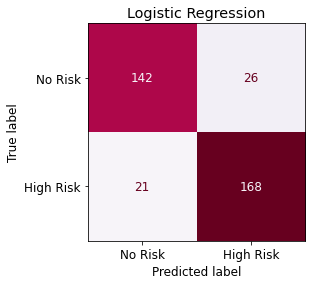

In [167]:
plt.rcParams.update({'font.size': 12}) 
metrics.plot_confusion_matrix(lr_gs, X_test, y_test, cmap = 'PuRd',colorbar = False, display_labels = ['No Risk','High Risk']);
plt.title('Logistic Regression');

In [168]:
grid_df = add_2_grid(lr_gs, X_test, y_test, 'Logistic Regression')
grid_df

,Notes,Recall,Precision,Accuracy
0,Logistic Regression,0.888889,0.865979,0.868347


## Bagging Classifier

In [169]:
params = {
    'n_estimators' : [10, 50, 100],
    'bootstrap' : [True, False],
    'max_features' : [0.10, 0.25, ]}

bag_gs = GridSearchCV(BaggingClassifier(),
                      params,
                      cv = 5,
                      verbose = 1)

bag_gs.fit(X_train,y_train)
bag_gs.best_params_, bag_gs.best_score_

Fitting 5 folds for each of 12 candidates, totalling 60 fits


({'bootstrap': False, 'max_features': 0.1, 'n_estimators': 100},
 0.9099559916311953)

In [170]:
print('Train:', bag_gs.score(X_train, y_train))
print('Test:', bag_gs.score(X_test, y_test))

Train: 1.0
Test: 0.9103641456582633


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


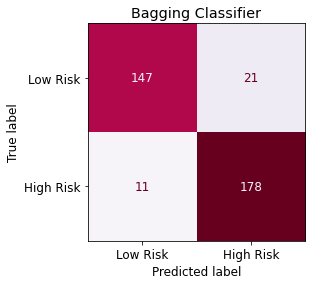

In [171]:
plt.rcParams.update({'font.size': 12}) 
metrics.plot_confusion_matrix(bag_gs, X_test, y_test, cmap = 'PuRd',colorbar = False, display_labels = ['Low Risk','High Risk']);
plt.title('Bagging Classifier');

In [172]:
grid_df = add_2_grid(bag_gs, X_test, y_test, 'Bagging Classifier')
grid_df

,Notes,Recall,Precision,Accuracy
0,Logistic Regression,0.888889,0.865979,0.868347
0,Bagging Classifier,0.941799,0.894472,0.910364


## Ada Boost <span id = 'ada'>

In [173]:
ada = AdaBoostClassifier()
params = {
    #'base_estimator__max_depth': [2, 3, 4, 5],
    'n_estimators' : [50, 100, 150],
    'learning_rate' : [1, 0.5, 0.1]
}

ada_gs = GridSearchCV(ada,
                      params,
                      cv = 4)

ada_gs.fit(X_train,y_train)
ada_gs.best_params_, ada_gs.best_score_

({'learning_rate': 1, 'n_estimators': 100}, 0.8775591185130658)

In [174]:
print('Train:', ada_gs.score(X_train, y_train))
print('Test:', ada_gs.score(X_test, y_test))

Train: 0.9411764705882353
Test: 0.8851540616246498


> The ada_gs did some 3% worse than the base model ada @ 0.913165

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


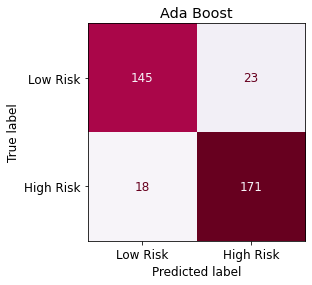

In [175]:
plt.rcParams.update({'font.size': 12}) 
metrics.plot_confusion_matrix(ada_gs, X_test, y_test, cmap = 'PuRd',colorbar = False, display_labels = ['Low Risk','High Risk']);
plt.title('Ada Boost')
plt.show()

In [176]:
grid_df = add_2_grid(ada_gs, X_test, y_test, 'Ada Boost')
grid_df

,Notes,Recall,Precision,Accuracy
0,Logistic Regression,0.888889,0.865979,0.868347
0,Bagging Classifier,0.941799,0.894472,0.910364
0,Ada Boost,0.904762,0.881443,0.885154


## Gradient Boosting <span id ='gb'>

In [177]:
params  = {'learning_rate':[1, 0.1,0.5],
          'n_estimators':[150, 200, 300],
          'max_depth':[2, 3, 4]}

gs_model = GridSearchCV(estimator =GradientBoostingClassifier(), 
                        param_grid = params,
                        n_jobs=4,
                        cv=3,
                        verbose = 1)
gs_model.fit(X_train,y_train)
gs_model.best_params_, gs_model.best_score_

Fitting 3 folds for each of 27 candidates, totalling 81 fits


({'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 150},
 0.8931555116917297)

In [178]:
print('Train:', gs_model.score(X_train, y_train))
print('Test:', gs_model.score(X_test, y_test))

Train: 0.9915966386554622
Test: 0.9103641456582633


> With gridsearch we see a 2.3% increase of **testing** score compared to the base model @ 0.904762

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


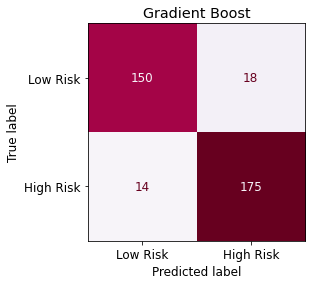

In [179]:
plt.rcParams.update({'font.size': 12}) 
metrics.plot_confusion_matrix(gs_model, X_test, y_test, cmap = 'PuRd',colorbar = False, display_labels = ['Low Risk','High Risk']);
plt.title('Gradient Boost');
plt.show()

In [180]:
grid_df = add_2_grid(gs_model, X_test, y_test, 'Gradient Boost 1')
grid_df

,Notes,Recall,Precision,Accuracy
0,Logistic Regression,0.888889,0.865979,0.868347
0,Bagging Classifier,0.941799,0.894472,0.910364
0,Ada Boost,0.904762,0.881443,0.885154
0,Gradient Boost 1,0.925926,0.906736,0.910364


## Random Forest <span id = 'rf'>

In [181]:
params = {
    'n_estimators' :[100, 200],
    'max_depth' : [50, None],
    'min_samples_split' : [2, 4],
    'min_samples_leaf' : [1, 3],
}

rf_gs = GridSearchCV(RandomForestClassifier(random_state=1663),
                     params,
                     cv = 5,
                     verbose=1)

rf_gs.fit(X_train,y_train)
rf_gs.best_params_, rf_gs.best_score_

Fitting 5 folds for each of 16 candidates, totalling 80 fits


({'max_depth': 50,
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'n_estimators': 100},
 0.9063559627732488)

In [182]:
print('Train:', rf_gs.score(X_train, y_train))
print('Test:', rf_gs.score(X_test, y_test))

Train: 1.0
Test: 0.9159663865546218


> With the gridsearch, we seem to have gotten the same score as the base model @  0.915966, suggesting the default parameters were the best choice out of what we gave.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


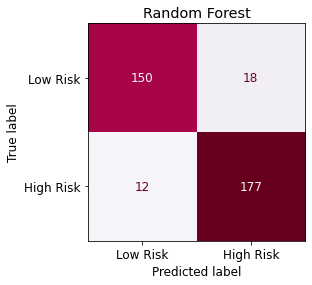

In [183]:
plt.rcParams.update({'font.size': 12}) 
metrics.plot_confusion_matrix(rf_gs, X_test, y_test, cmap = 'PuRd',colorbar = False, display_labels = ['Low Risk','High Risk']);
plt.title('Random Forest');

In [184]:
grid_df = add_2_grid(rf_gs, X_test, y_test, 'Random Forest')
grid_df

,Notes,Recall,Precision,Accuracy
0,Logistic Regression,0.888889,0.865979,0.868347
0,Bagging Classifier,0.941799,0.894472,0.910364
0,Ada Boost,0.904762,0.881443,0.885154
0,Gradient Boost 1,0.925926,0.906736,0.910364
0,Random Forest,0.936508,0.907692,0.915966


## Decision Tree <span id ='dt'>

In [185]:
params = {
    'criterion' : ['gini', 'entropy'],
    'min_samples_split' : [2, 5, 11],
    'min_samples_leaf' : [1, 2, 3],
    'ccp_alpha': [1, 0.1, 0],
}

dt_gs = GridSearchCV(DecisionTreeClassifier(),
                     params,
                     cv = 5,
                     verbose = 1)

dt_gs.fit(X_train,y_train)
dt_gs.best_params_, dt_gs.best_score_

Fitting 5 folds for each of 54 candidates, totalling 270 fits


({'ccp_alpha': 0,
  'criterion': 'entropy',
  'min_samples_leaf': 1,
  'min_samples_split': 2},
 0.8667340018757665)

In [186]:
dt_gs.best_params_, dt_gs.best_score_

({'ccp_alpha': 0,
  'criterion': 'entropy',
  'min_samples_leaf': 1,
  'min_samples_split': 2},
 0.8667340018757665)

In [187]:
print('Train:', dt_gs.score(X_train, y_train))
print('Test:', dt_gs.score(X_test, y_test))

Train: 1.0
Test: 0.8599439775910365


> Super overfit, but i guess thats expected from a decision tree. Guess we can just ignore this one as a model

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


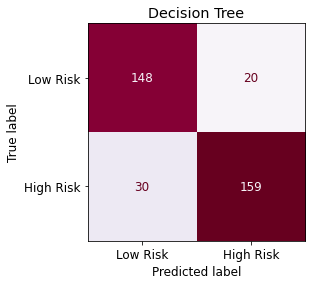

In [188]:
plt.rcParams.update({'font.size': 12}) 
metrics.plot_confusion_matrix(dt_gs, X_test, y_test, cmap = 'PuRd',colorbar = False, display_labels = ['Low Risk','High Risk']);
plt.title('Decision Tree');

In [189]:
grid_df = add_2_grid(dt_gs, X_test, y_test, 'Decision Tree')
grid_df

,Notes,Recall,Precision,Accuracy
0,Logistic Regression,0.888889,0.865979,0.868347
0,Bagging Classifier,0.941799,0.894472,0.910364
0,Ada Boost,0.904762,0.881443,0.885154
0,Gradient Boost 1,0.925926,0.906736,0.910364
0,Random Forest,0.936508,0.907692,0.915966
0,Decision Tree,0.841270,0.888268,0.859944


## SVC <span id = 'svc'>

In [190]:
params = {
    'C' : [0.1, 1, 2],
    'kernel' : ['poly', 'rbf', 'sigmoid'],
    'degree' : [2, 3, 4],
}

svc_gs = GridSearchCV(SVC(),
                      params,
                      cv = 5,
                      verbose = 1)

svc_gs.fit(X_train, y_train)
svc_gs.best_params_, svc_gs.best_score_


Fitting 5 folds for each of 27 candidates, totalling 135 fits


({'C': 2, 'degree': 2, 'kernel': 'rbf'}, 0.7142774691580694)

In [191]:
print('Train:', svc_gs.score(X_train, y_train))
print('Test:', svc_gs.score(X_test, y_test))

Train: 0.723889555822329
Test: 0.7647058823529411


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


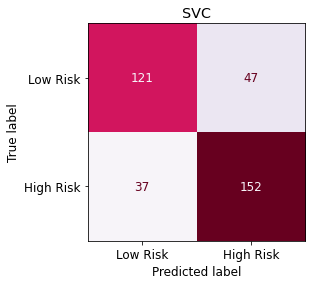

In [192]:
plt.rcParams.update({'font.size': 12}) 
metrics.plot_confusion_matrix(svc_gs, X_test, y_test, cmap = 'PuRd',colorbar = False, display_labels = ['Low Risk','High Risk']);
plt.title('SVC');

In [193]:
grid_df = add_2_grid(svc_gs, X_test, y_test, 'SVC')
grid_df

,Notes,Recall,Precision,Accuracy
0,Logistic Regression,0.888889,0.865979,0.868347
0,Bagging Classifier,0.941799,0.894472,0.910364
0,Ada Boost,0.904762,0.881443,0.885154
0,Gradient Boost 1,0.925926,0.906736,0.910364
0,Random Forest,0.936508,0.907692,0.915966
0,Decision Tree,0.841270,0.888268,0.859944
0,SVC,0.804233,0.763819,0.764706


## KNN <span id = 'hknn'>

In [194]:
params = {
    'n_neighbors' : np.arange(1, 20, 2),
    'leaf_size' : [10, 20, 30 , 40],
    'metric' : ['euclidean', 'minkowski','manhattan']
}

knn_gs = GridSearchCV(KNeighborsClassifier(),
                      params,
                      cv = 5,
                      verbose = 1)

knn_gs.fit(X_train, y_train)
knn_gs.best_params_, knn_gs.best_score_

Fitting 5 folds for each of 120 candidates, totalling 600 fits


({'leaf_size': 10, 'metric': 'manhattan', 'n_neighbors': 1},
 0.7790924175744897)

In [195]:
print('Train:', knn_gs.score(X_train, y_train))
print('Test:', knn_gs.score(X_test, y_test))

Train: 1.0
Test: 0.8291316526610645


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


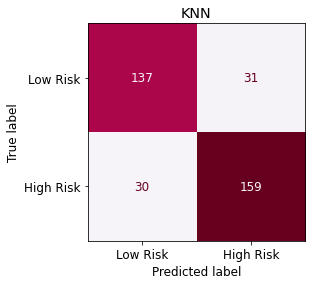

In [196]:
plt.rcParams.update({'font.size': 12}) 
metrics.plot_confusion_matrix(knn_gs, X_test, y_test, cmap = 'PuRd',colorbar = False, display_labels = ['Low Risk','High Risk']);
plt.title('KNN');

In [197]:
grid_df = add_2_grid(knn_gs, X_test, y_test, 'KNN')
grid_df

,Notes,Recall,Precision,Accuracy
0,Logistic Regression,0.888889,0.865979,0.868347
0,Bagging Classifier,0.941799,0.894472,0.910364
0,Ada Boost,0.904762,0.881443,0.885154
0,Gradient Boost 1,0.925926,0.906736,0.910364
0,Random Forest,0.936508,0.907692,0.915966
0,Decision Tree,0.841270,0.888268,0.859944
0,SVC,0.804233,0.763819,0.764706
0,KNN,0.841270,0.836842,0.829132


## BNB <span id ='hbnb'>

In [198]:
params = {
    'alpha' : [1, 0.5, 1.0e-10],
}

bnb_gs = GridSearchCV(BernoulliNB(),
                      params,
                      cv = 5,
                      verbose = 1)

bnb_gs.fit(X_train, y_train)
bnb_gs.best_params_, bnb_gs.best_score_

Fitting 5 folds for each of 3 candidates, totalling 15 fits


({'alpha': 1}, 0.7455161965226175)

In [199]:
print('Train:', bnb_gs.score(X_train, y_train))
print('Test:', bnb_gs.score(X_test, y_test))

Train: 0.7454981992797118
Test: 0.742296918767507


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


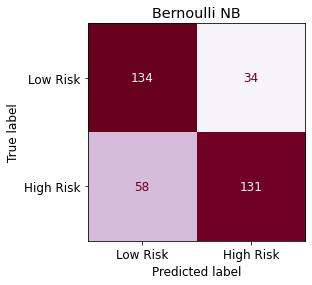

In [200]:
plt.rcParams.update({'font.size': 12}) 
metrics.plot_confusion_matrix(bnb_gs, X_test, y_test, cmap = 'PuRd',colorbar = False, display_labels = ['Low Risk','High Risk']);
plt.title('Bernoulli NB');

In [201]:
grid_df = add_2_grid(bnb_gs, X_test, y_test, 'Bernoulli Naive Bayes')
grid_df

,Notes,Recall,Precision,Accuracy
0,Logistic Regression,0.888889,0.865979,0.868347
0,Bagging Classifier,0.941799,0.894472,0.910364
0,Ada Boost,0.904762,0.881443,0.885154
0,Gradient Boost 1,0.925926,0.906736,0.910364
0,Random Forest,0.936508,0.907692,0.915966
0,Decision Tree,0.841270,0.888268,0.859944
0,SVC,0.804233,0.763819,0.764706
0,KNN,0.841270,0.836842,0.829132
0,Bernoulli Naive Bayes,0.693122,0.793939,0.742297


## Neural Network <span id = 'nn'>

In [202]:
sc = StandardScaler()
Z_train = sc.fit_transform(X_train)
Z_test = sc.transform(X_test)

In [203]:
Z_train.shape

(833, 53)

In [204]:
model = Sequential()

## Add input and hidden layer (first dense layer)
model.add(Dense(64,
               activation = 'relu',
               input_shape = Z_train[0].shape))
model.add(Dropout(0.05))

## Add 2nd & 3rd hidden layer
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.05))

model.add(Dense(32, activation = 'relu'))
model.add(Dropout(0.05))

## Output layer
model.add(Dense(1, activation = 'sigmoid'))

# adding in earlystopping
es = EarlyStopping(patience=5)

# Compile our data
model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [205]:
results = model.fit(Z_train, y_train,
                    batch_size= 15,
                    epochs=10,
                    validation_data=(Z_test, y_test),
                    verbose = 1)

Epoch 1/10
56/56 [==============================] - 1s 6ms/step - loss: 0.4747 - accuracy: 0.7683 - val_loss: 0.3859 - val_accuracy: 0.8515
Epoch 2/10
56/56 [==============================] - 0s 3ms/step - loss: 0.3735 - accuracy: 0.8439 - val_loss: 0.3596 - val_accuracy: 0.8543
Epoch 3/10
56/56 [==============================] - 0s 4ms/step - loss: 0.3502 - accuracy: 0.8547 - val_loss: 0.3544 - val_accuracy: 0.8655
Epoch 4/10
56/56 [==============================] - 0s 4ms/step - loss: 0.3374 - accuracy: 0.8559 - val_loss: 0.3448 - val_accuracy: 0.8683
Epoch 5/10
56/56 [==============================] - 0s 3ms/step - loss: 0.3110 - accuracy: 0.8776 - val_loss: 0.3435 - val_accuracy: 0.8739
Epoch 6/10
56/56 [==============================] - 0s 4ms/step - loss: 0.3031 - accuracy: 0.8752 - val_loss: 0.3472 - val_accuracy: 0.8683
Epoch 7/10
56/56 [==============================] - 0s 3ms/step - loss: 0.2863 - accuracy: 0.8739 - val_loss: 0.3530 - val_accuracy: 0.8739
Epoch 8/10
56/56 [==

## Gradient Boosting Part 2 <span id = 'gd_boost2'>

In [206]:
params  = {'learning_rate':[0.15, 0.1],
           'n_estimators':[150, 250],
           'max_depth':[5, 6]}

gs_model_2 = GridSearchCV(GradientBoostingClassifier(min_samples_split=2), 
                        param_grid = params, scoring='accuracy', n_jobs=4,  cv=5,
                        verbose =1)
gs_model_2.fit(X_train,y_train)
print(gs_model_2.best_params_, gs_model_2.best_score_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 250} 0.9016016160450183


In [207]:
print('Train:', gs_model_2.score(X_train, y_train))
print('Test:', gs_model_2.score(X_test, y_test))

Train: 1.0
Test: 0.9159663865546218


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


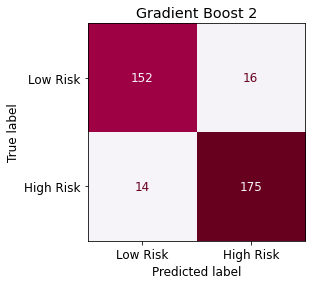

In [208]:
plt.rcParams.update({'font.size': 12}) 
metrics.plot_confusion_matrix(gs_model_2, X_test, y_test, cmap = 'PuRd',colorbar = False, display_labels = ['Low Risk','High Risk']);
plt.title('Gradient Boost 2');

In [209]:
grid_df = add_2_grid(gs_model_2, X_test, y_test, 'Gradient Boost 2')
grid_df

,Notes,Recall,Precision,Accuracy
0,Logistic Regression,0.888889,0.865979,0.868347
0,Bagging Classifier,0.941799,0.894472,0.910364
0,Ada Boost,0.904762,0.881443,0.885154
0,Gradient Boost 1,0.925926,0.906736,0.910364
0,Random Forest,0.936508,0.907692,0.915966
0,Decision Tree,0.841270,0.888268,0.859944
0,SVC,0.804233,0.763819,0.764706
0,KNN,0.841270,0.836842,0.829132
0,Bernoulli Naive Bayes,0.693122,0.793939,0.742297
0,Gradient Boost 2,0.925926,0.916230,0.915966


## Plotting 10 most important features From Gradient Boost updated

Accuracy of GBC on testing data: 0.9272
              precision    recall  f1-score   support

           0       0.94      0.90      0.92       168
           1       0.91      0.95      0.93       189

    accuracy                           0.93       357
   macro avg       0.93      0.93      0.93       357
weighted avg       0.93      0.93      0.93       357



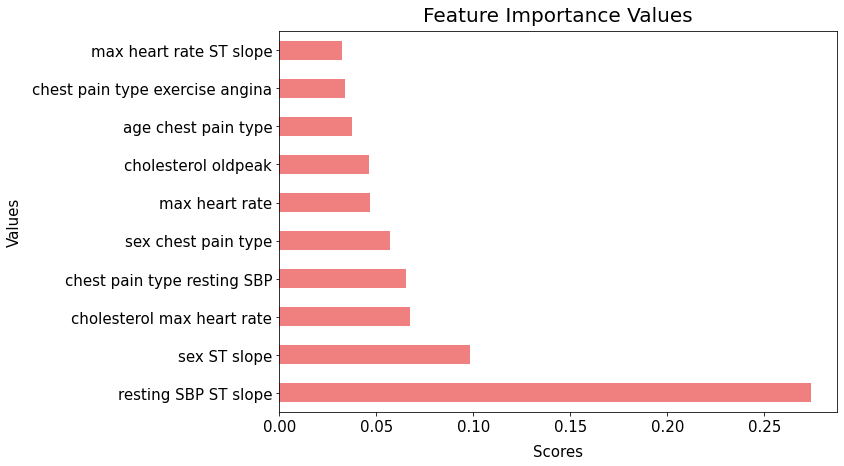

In [210]:
model1 = GradientBoostingClassifier(learning_rate=0.5, n_estimators=200,
                                    max_depth=4, min_samples_split=2)
model1.fit(X_train,y_train)
predictors=list(X_train)
plt.figure(figsize = (10, 7))
imp_features = pd.Series(model1.feature_importances_, predictors).sort_values(ascending=False)
imp_features[:10].plot(kind='barh', title='Importance of Features', color = 'lightcoral')
plt.title('Feature Importance Values', fontsize = 20, pad  = 10)
plt.ylabel('Values', fontsize = 15, labelpad = 10)
plt.yticks(size = 15)
plt.xlabel('Scores', fontsize = 15, labelpad = 10)
plt.xticks(size = 15)
print('Accuracy of GBC on testing data: {:.4f}'.format(model1.score(X_test, y_test)))
y_pred=model1.predict(X_test)
print(classification_report(y_test, y_pred))

# plt.savefig('./imgs/imp_of_features.png',dpi=300, bbox_inches = "tight")

## Voting Classifier <span id = 'voting'>

In [211]:
# need to scale it for the certain models
svc_pipe = Pipeline([
    ('sc', StandardScaler()),
    ('svc', SVC())
])

knn_pipe = Pipeline([
    ('sc', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

log_pipe = Pipeline([
    ('sc', StandardScaler()),
    ('log', LogisticRegression(max_iter=1000))
])

# making the voting classifier model
vote = VotingClassifier([
    ('ada', AdaBoostClassifier()),
    ('gb', model1),
    ('bag', BaggingClassifier()),
    ('svc', svc_pipe),
    ('log', log_pipe),
    ('rf', RandomForestClassifier(max_depth = 50, n_estimators = 200)),
    ('knn_pipe', knn_pipe)])
vote.fit(X_train, y_train)

VotingClassifier(estimators=[('ada', AdaBoostClassifier()),
                             ('gb',
                              GradientBoostingClassifier(learning_rate=0.5,
                                                         max_depth=4,
                                                         n_estimators=200)),
                             ('bag', BaggingClassifier()),
                             ('svc',
                              Pipeline(steps=[('sc', StandardScaler()),
                                              ('svc', SVC())])),
                             ('log',
                              Pipeline(steps=[('sc', StandardScaler()),
                                              ('log',
                                               LogisticRegression(max_iter=1000))])),
                             ('rf',
                              RandomForestClassifier(max_depth=50,
                                                     n_estimators=200)),
                       

In [212]:
print(vote.score(X_train, y_train))
print(vote.score(X_test, y_test))

0.9483793517406963
0.9019607843137255


**Model Scores**  
Overall, the best model we had for *accuracy* was the Gradient boosting at a 0.9244, followed by the Random Forest Model, which had 0.91036

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


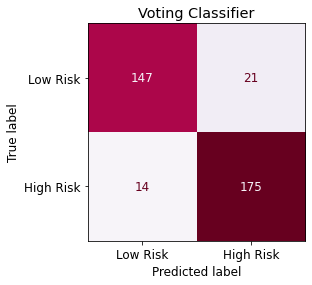

In [213]:
plt.rcParams.update({'font.size': 12}) 
metrics.plot_confusion_matrix(vote, X_test, y_test, cmap = 'PuRd',colorbar = False, display_labels = ['Low Risk','High Risk']);
plt.title('Voting Classifier');

In [214]:
grid_df = add_2_grid(vote, X_test, y_test, 'Voting Classifier')
grid_df

,Notes,Recall,Precision,Accuracy
0,Logistic Regression,0.888889,0.865979,0.868347
0,Bagging Classifier,0.941799,0.894472,0.910364
0,Ada Boost,0.904762,0.881443,0.885154
0,Gradient Boost 1,0.925926,0.906736,0.910364
0,Random Forest,0.936508,0.907692,0.915966
0,Decision Tree,0.841270,0.888268,0.859944
0,SVC,0.804233,0.763819,0.764706
0,KNN,0.841270,0.836842,0.829132
0,Bernoulli Naive Bayes,0.693122,0.793939,0.742297
0,Gradient Boost 2,0.925926,0.916230,0.915966


<span id ='gridsearch_scores'></span>
## Data Frame of all our GridSearch scores, with Recall, Precision, Accuracy

In [215]:
grid_df.reset_index(inplace=True)
grid_df.drop('index', axis = 1, inplace = True)

grid_df

,Notes,Recall,Precision,Accuracy
0,Logistic Regression,0.888889,0.865979,0.868347
1,Bagging Classifier,0.941799,0.894472,0.910364
2,Ada Boost,0.904762,0.881443,0.885154
3,Gradient Boost 1,0.925926,0.906736,0.910364
4,Random Forest,0.936508,0.907692,0.915966
5,Decision Tree,0.841270,0.888268,0.859944
6,SVC,0.804233,0.763819,0.764706
7,KNN,0.841270,0.836842,0.829132
8,Bernoulli Naive Bayes,0.693122,0.793939,0.742297
9,Gradient Boost 2,0.925926,0.916230,0.915966


<span id = 'hanalysis'></span>
# Analysis of Data using Gradient Boost 3 model

In [216]:
for i in range(10):
    print(f'{imp_features.index[i]}: {round(imp_features[i],5)}')
    print('---'*13)

resting SBP ST slope: 0.27381
---------------------------------------
sex ST slope: 0.09808
---------------------------------------
cholesterol max heart rate: 0.06725
---------------------------------------
chest pain type resting SBP: 0.06508
---------------------------------------
sex chest pain type: 0.05688
---------------------------------------
max heart rate: 0.04679
---------------------------------------
cholesterol oldpeak: 0.04647
---------------------------------------
age chest pain type: 0.03742
---------------------------------------
chest pain type exercise angina: 0.03378
---------------------------------------
max heart rate ST slope: 0.0322
---------------------------------------


<span id = 'hcnr'></span>
### Conclusions and Recommendations
![image.png](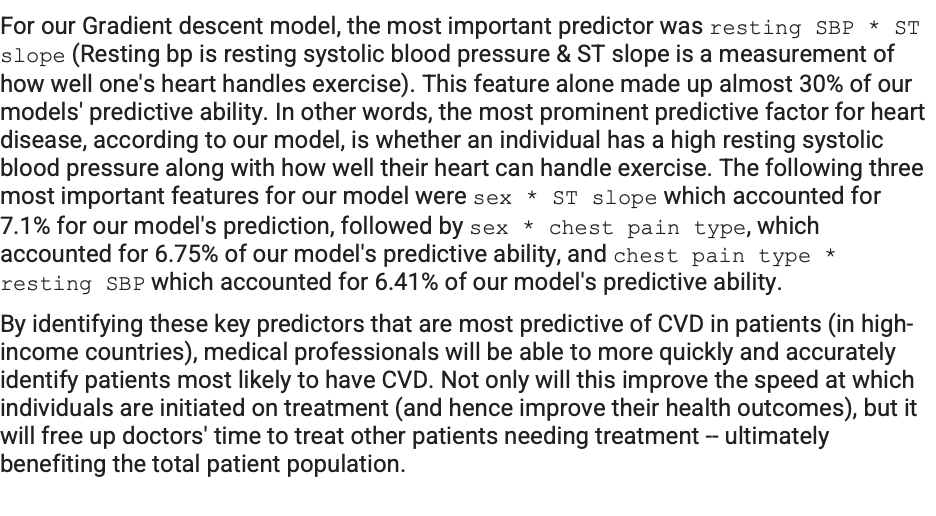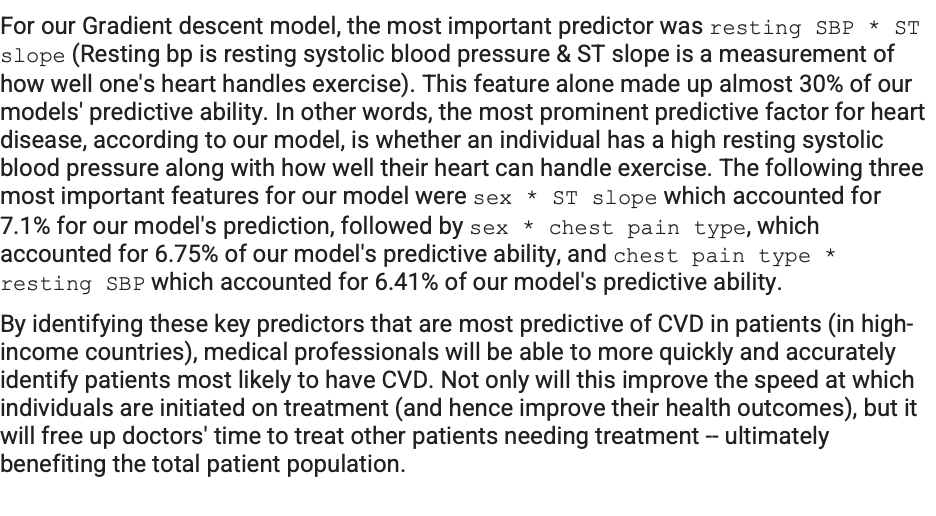)  For our Gradient descent model, the most important predictor was `resting SBP * ST slope` (Resting bp is resting systolic blood pressure & ST slope is a measurement of how well one's heart handles exercise). This feature alone made up almost 30% of our models' predictive ability.  In other words, the most prominent predictive factor for heart disease, according to our model, is whether an individual has a high resting systolic blood pressure along with how well their heart can handle exercise.  The next three most important features for our model were `sex * ST slope` which accounted for 7.1% for our model's prediction, followed by `sex * chest pain type`, which accounted for 6.75% of our model's predictive ability, and `chest pain type * resting SBP` which accounted for 6.41% of our model's predictive ability.

  By identifying these key predictors that are most predictive of CVD in patients (in high-income countries), medical professionals will be able to more quickly and accurately identify patients most likely to have CVD.  Not only will this improve the speed at which individuals are initiated on treatment (and hence improve their health outcomes), but it will free up doctors' time to treat other patients needing treatment -- ultimately benefiting the total patient population.

---

<span id='jen'></span>
# CHD work

**Data Dictionary**

|    | Column Name              | Description                                                                                                                                                                                                                                       | Type    |
|---:|:-------------------------|:--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:--------|
|  | state_abbr               | State abbreviation                                                                                                                                                                                                                                | Object  |
|  | state                    | State name                                                                                                                                                                                                                                        | Object  |
|  | county                   | County name                                                                                                                                                                                                                                       | Object  |
|  | county_fips              | County fips code                                                                                                                                                                                                                                  | Integer |
|  | tract_fips               | Census tract fips code                                                                                                                                                                                                                            | Integer |
|  | total_pop                | Total Population of Census 2010                                                                                                                                                                                                                   | Integer |
|  | access_to_healthcare     | Model-based estimate for crude prevalence of current lack of health insurance among adults aged 18-64 years, 2018                                                                                                                                 | Float   |
|  | arthritis                | Model-based estimate for crude prevalence of arthritis among adults aged >=18 years, 2018                                                                                                                                                         | Float   |
|  | binge_drinking           | Model-based estimate for crude prevalence of binge drinking among adults aged >=18 years, 2018                                                                                                                                                    | Float   |
|  | high_bp                  | Model-based estimate for crude prevalence of high blood pressure among adults aged >=18 years, 2017                                                                                                                                               | Float   |
|  | meds_for_high_bp         | Model-based estimate for crude prevalence of taking medicine for high blood pressure control among adults aged >=18 years with high blood pressure, 2017                                                                                          | Float   |
|  | cancer                   | Model-based estimate for crude prevalence of cancer (excluding skin cancer) among adults aged >=18 years, 2018                                                                                                                                    | Float   |
|  | current_asthma           | Model-based estimate for crude prevalence of current asthma among adults aged >=18 years, 2018                                                                                                                                                    | Float   |
|  | cervical_screening       | Model-based estimate for crude prevalence of cervical cancer screening among adult women aged 21–65 years, 2018                                                                                                                                   | Float   |
|  | chd                      | Model-based estimate for crude prevalence of coronary heart disease among adults aged >=18 years, 2018                                                                                                                                            | Float   |
|  | doc_checkups             | Model-based estimate for crude prevalence of visits to doctor for routine checkup within the past year among adults aged >=18 years, 2018                                                                                                         | Float   |
|  | chol_screen              | Model-based estimate for crude prevalence of cholesterol screening among adults aged >=18 years, 2017                                                                                                                                             | Float   |
|  | colon_screen             | Model-based estimate for crude prevalence of fecal occult blood test, sigmoidoscopy, or colonoscopy among adults aged 50–75 years, 2018                                                                                                           | Float   |
|  | copd                     | Model-based estimate for crude prevalence of chronic obstructive pulmonary disease among adults aged >=18 years, 2018                                                                                                                             | Float   |
|  | core_preventative_men    | Model-based estimate for crude prevalence of older adult men aged >=65 years who are up to date on a core set of clinical preventive services: Flu shot past year, PPV shot ever, Colorectal cancer screening, 2018                               | Float   |
|  | core_preventative_female | Model-based estimate for crude prevalence of older adult women aged >=65 years who are up to date on a core set of clinical preventive services: Flu shot past year, PPV shot ever, Colorectal cancer screening, and Mammogram past 2 years, 2018 | Float   |
|  | current_smoker           | Model-based estimate for crude prevalence of current smoking among adults aged >=18 years, 2018                                                                                                                                                   | Float   |
|  | dental_visits            | Model-based estimate for crude prevalence of visits to dentist or dental clinic among adults aged >=18 years, 2018                                                                                                                                | Float   |
|  | diabetes                 | Model-based estimate for crude prevalence of diagnosed diabetes among adults aged >=18 years, 2018                                                                                                                                                | Float   |
|  | high_chol                | Model-based estimate for crude prevalence of high cholesterol among adults aged >=18 years who have been screened in the past 5 years, 2017                                                                                                       | Float   |
|  | kidney_disease           | Model-based estimate for crude prevalence of chronic kidney disease among adults aged >=18 years, 2018                                                                                                                                            | Float   |
|  | physical_activity        | Model-based estimate for crude prevalence of no leisure-time physical activity among adults aged >=18 years, 2018                                                                                                                                 | Float   |
|  | mammography              | Model-based estimate for crude prevalence of mammography use among women aged 50–74 years, 2018                                                                                                                                                   | Float   |
|  | mental_health            | Model-based estimate for crude prevalence of mental health not good for >=14 days among adults aged >=18 years, 2018                                                                                                                              | Float   |
|  | obesity                  | Model-based estimate for crude prevalence of obesity among adults aged >=18 years, 2018                                                                                                                                                           | Float   |
|  | poor_physical_health     | Model-based estimate for crude prevalence of physical health not good for >=14 days among adults aged >=18 years, 2018                                                                                                                            | Float   |
|  | poor_sleep               | Model-based estimate for crude prevalence of sleeping less than 7 hours among adults aged >=18 years, 2018                                                                                                                                        | Float   |
|  | stroke                   | Model-based estimate for crude prevalence of stroke among adults aged >=18 years, 2018                                                                                                                                                            | Float   |
|  | teeth_lost               | Model-based estimate for crude prevalence of all teeth lost among adults aged >=65 years, 2018                                                                                                                                                    | Float   |

## Cleaning and EDA <span id='jclean'>

In [217]:
df = pd.read_csv('/content/PLACES__Census_Tract_Data__GIS_Friendly_Format___2020_release.csv')
df.head()

,StateAbbr,StateDesc,CountyName,CountyFIPS,TractFIPS,TotalPopulation,ACCESS2_CrudePrev,ARTHRITIS_CrudePrev,BINGE_CrudePrev,BPHIGH_CrudePrev,BPMED_CrudePrev,CANCER_CrudePrev,CASTHMA_CrudePrev,CERVICAL_CrudePrev,CHD_CrudePrev,CHECKUP_CrudePrev,CHOLSCREEN_CrudePrev,COLON_SCREEN_CrudePrev,COPD_CrudePrev,COREM_CrudePrev,COREW_CrudePrev,CSMOKING_CrudePrev,DENTAL_CrudePrev,DIABETES_CrudePrev,HIGHCHOL_CrudePrev,KIDNEY_CrudePrev,LPA_CrudePrev,MAMMOUSE_CrudePrev,MHLTH_CrudePrev,OBESITY_CrudePrev,PHLTH_CrudePrev,SLEEP_CrudePrev,STROKE_CrudePrev,TEETHLOST_CrudePrev
0,CA,California,Contra Costa,6013,6013312000,2292,20.2,26.5,14.0,34.1,73.8,5.9,12.0,82.6,7.1,72.5,78.5,62.7,7.8,22.3,22.0,17.8,51.3,15.3,31.0,4.1,29.4,79.8,16.8,33.3,18.4,40.1,5.0,22.0
1,CA,California,Contra Costa,6013,6013329000,6309,11.9,19.8,19.7,23.5,67.3,5.8,9.1,86.1,4.3,68.4,80.4,70.6,4.6,33.3,31.0,11.7,71.2,7.7,28.3,2.3,17.0,79.1,12.1,23.2,11.0,32.4,2.3,8.8
2,CA,California,Contra Costa,6013,6013346203,3838,5.1,24.2,16.9,26.0,73.7,8.4,8.6,89.3,4.9,74.0,88.2,77.5,4.3,38.0,35.8,7.6,81.1,7.7,32.2,2.5,12.3,81.3,9.0,20.7,9.5,27.7,2.4,4.8
3,CA,California,Los Angeles,6037,6037134421,3941,5.7,20.9,17.8,26.1,71.9,7.8,7.8,87.3,4.8,74.9,88.2,74.8,4.4,40.9,37.2,8.1,78.6,8.3,34.6,2.4,13.0,79.1,9.3,21.0,9.3,30.9,2.4,4.6
4,CA,California,Los Angeles,6037,6037135114,4445,9.0,18.6,17.2,24.2,69.4,6.2,7.9,80.9,4.9,71.3,81.1,71.7,4.6,36.0,30.9,10.4,68.3,8.4,30.5,2.6,16.0,79.0,11.3,21.7,10.3,34.5,2.6,7.6


In [218]:
df.shape

(72337, 34)

In [219]:
df.dtypes

StateAbbr                  object
StateDesc                  object
CountyName                 object
CountyFIPS                  int64
TractFIPS                   int64
TotalPopulation             int64
ACCESS2_CrudePrev         float64
ARTHRITIS_CrudePrev       float64
BINGE_CrudePrev           float64
BPHIGH_CrudePrev          float64
BPMED_CrudePrev           float64
CANCER_CrudePrev          float64
CASTHMA_CrudePrev         float64
CERVICAL_CrudePrev        float64
CHD_CrudePrev             float64
CHECKUP_CrudePrev         float64
CHOLSCREEN_CrudePrev      float64
COLON_SCREEN_CrudePrev    float64
COPD_CrudePrev            float64
COREM_CrudePrev           float64
COREW_CrudePrev           float64
CSMOKING_CrudePrev        float64
DENTAL_CrudePrev          float64
DIABETES_CrudePrev        float64
HIGHCHOL_CrudePrev        float64
KIDNEY_CrudePrev          float64
LPA_CrudePrev             float64
MAMMOUSE_CrudePrev        float64
MHLTH_CrudePrev           float64
OBESITY_CrudeP

In [220]:
df.isnull().sum()

StateAbbr                   0
StateDesc                   0
CountyName                  0
CountyFIPS                  0
TractFIPS                   0
TotalPopulation             0
ACCESS2_CrudePrev           0
ARTHRITIS_CrudePrev         0
BINGE_CrudePrev             0
BPHIGH_CrudePrev            0
BPMED_CrudePrev             0
CANCER_CrudePrev            0
CASTHMA_CrudePrev           0
CERVICAL_CrudePrev         17
CHD_CrudePrev               0
CHECKUP_CrudePrev           0
CHOLSCREEN_CrudePrev        0
COLON_SCREEN_CrudePrev     33
COPD_CrudePrev              0
COREM_CrudePrev           144
COREW_CrudePrev           195
CSMOKING_CrudePrev          0
DENTAL_CrudePrev            0
DIABETES_CrudePrev          0
HIGHCHOL_CrudePrev          0
KIDNEY_CrudePrev            0
LPA_CrudePrev               0
MAMMOUSE_CrudePrev         84
MHLTH_CrudePrev             0
OBESITY_CrudePrev           0
PHLTH_CrudePrev             0
SLEEP_CrudePrev             0
STROKE_CrudePrev            0
TEETHLOST_

In [221]:
# Dropped all null values since it's a small amount of the data
df.dropna(axis = 0, how = 'any', inplace = True)

### Renaming Columns 

In [222]:
df_dict = {
    'StateAbbr': 'state_abbr', 
    'StateDesc': 'state',
    'CountyName':'county',
    'CountyFIPS':'county_fips',
    'TractFIPS': 'tract_fips',
    'TotalPopulation':'total_pop',
    'ACCESS2_CrudePrev':'access_to_healthcare',
    'ARTHRITIS_CrudePrev':'arthritis',
    'BINGE_CrudePrev':'binge_drinking',
    'BPHIGH_CrudePrev':'high_bp',
    'BPMED_CrudePrev':'meds_for_high_bp',
    'CANCER_CrudePrev':'cancer',
    'CASTHMA_CrudePrev':'current_asthma',
    'CERVICAL_CrudePrev':'cervical_screening',
    'CHD_CrudePrev':'chd',
    'CHECKUP_CrudePrev':'doc_checkups',
    'CHOLSCREEN_CrudePrev':'chol_screen',
    'COLON_SCREEN_CrudePrev':'colon_screen',
    'COPD_CrudePrev':'copd',
    'COREM_CrudePrev':'core_preventative_men',
    'COREW_CrudePrev':'core_preventative_female',
    'CSMOKING_CrudePrev':'current_smoker',
    'DENTAL_CrudePrev':'dental_visits',
    'DIABETES_CrudePrev':'diabetes',
    'HIGHCHOL_CrudePrev':'high_chol',
    'KIDNEY_CrudePrev':'kidney_disease',
    'LPA_CrudePrev':'physical_activity',
    'MAMMOUSE_CrudePrev':'mammography',
    'MHLTH_CrudePrev':'mental_health',
    'OBESITY_CrudePrev':'obesity',
    'PHLTH_CrudePrev':'poor_physical_health',
    'SLEEP_CrudePrev':'poor_sleep',
    'STROKE_CrudePrev':'stroke',
    'TEETHLOST_CrudePrev':'teeth_lost'
}

df.rename(columns = df_dict, inplace = True)

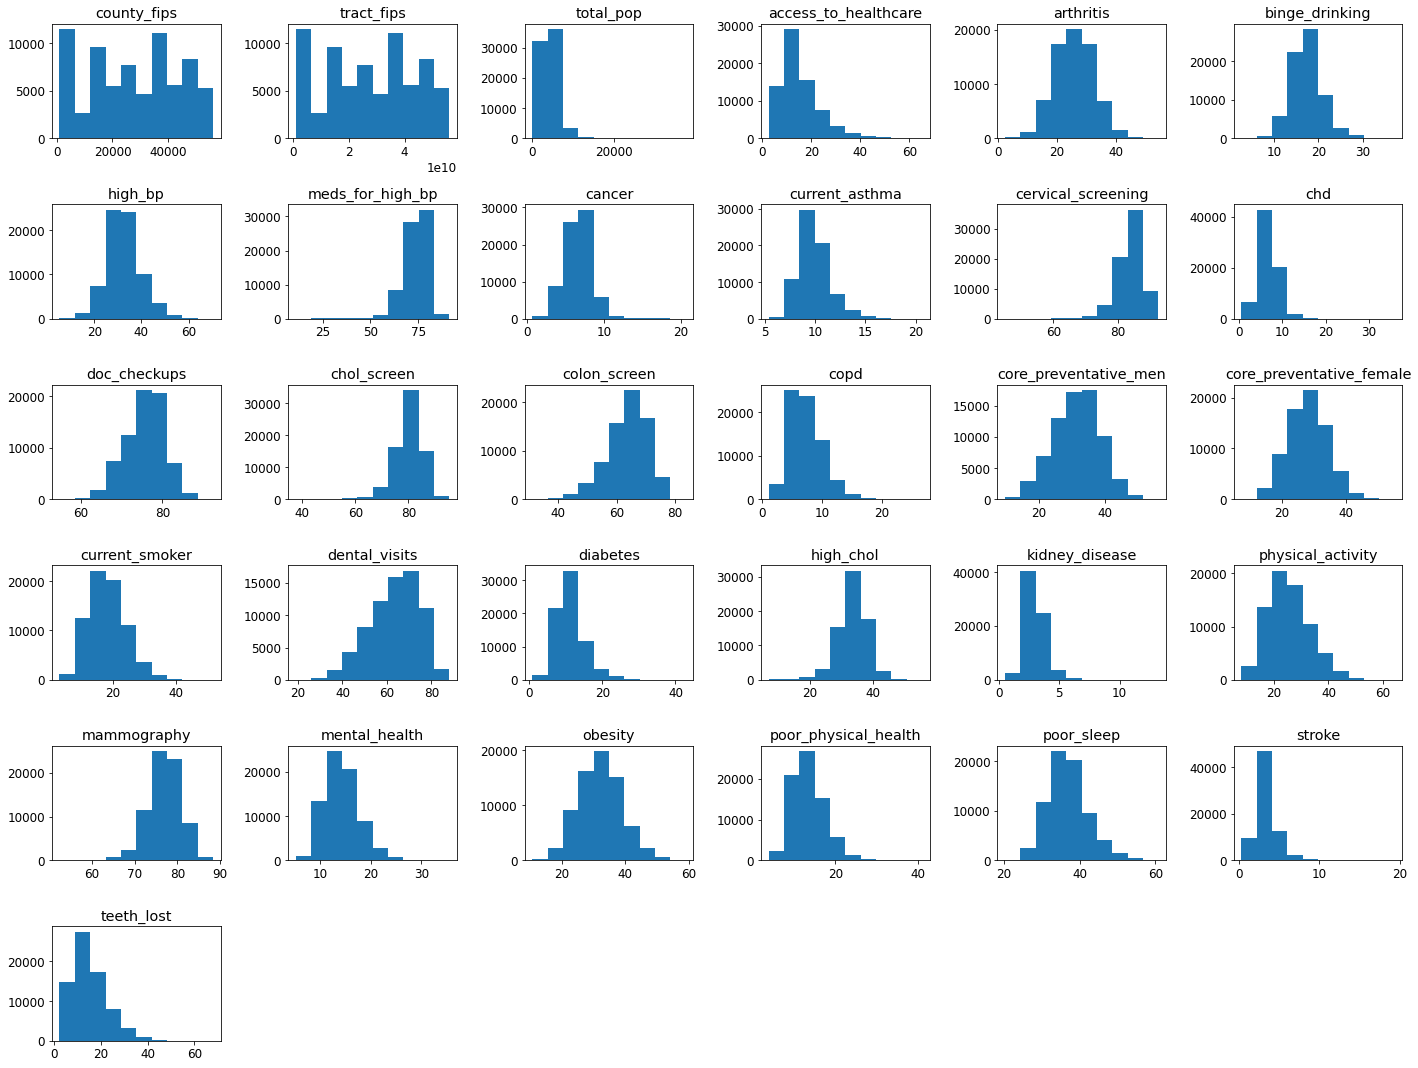

In [223]:
df.hist(figsize = (20,15), grid = False);
plt.tight_layout();

No major outliers identified. 

### Dummy column for states

In [224]:
state_df = df.groupby('state_abbr')[['chd']].mean().sort_values('chd', ascending = True)
pd.DataFrame(state_df).head()

,chd
state_abbr,
DC,4.346629
UT,4.528425
CO,5.030738
CA,5.296314
MD,5.666305


In [225]:
dummy = pd.get_dummies(df, columns = ['state_abbr'])
dummy.drop(columns = ['state_abbr_DC'], inplace = True) # DC has the lowest chd risk rate - dropping

df = pd.merge(df,dummy)

df.drop(columns = ['state_abbr'], inplace = True)

## Regression EDA <span id ='reg_eda'>

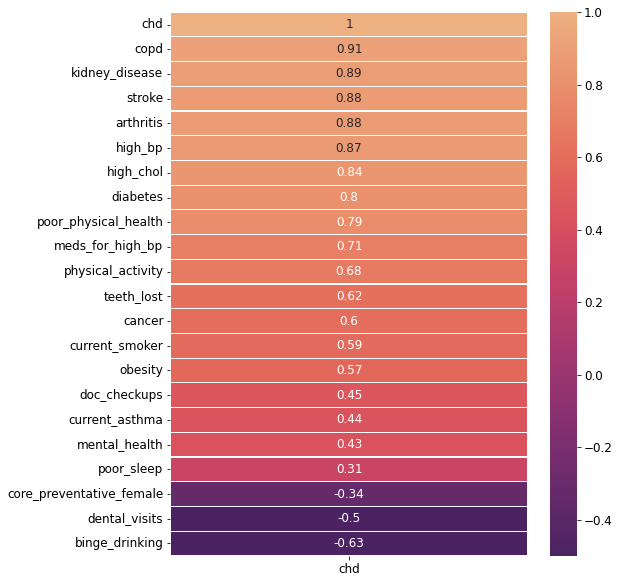

In [226]:
corr = df.corr()[['chd']]
corr = corr.loc[(corr['chd'] > .3) | (corr['chd'] < -0.29)]

# Heatmap
plt.figure(figsize = (8,10))
sns.heatmap(data = corr.sort_values(by = 'chd', ascending = False),
           annot = True,
           linewidths=0.1,
           cmap = 'flare_r',
           vmin=-0.5, 
           vmax=1);

# plt.savefig('./imgs/chd_reg_corr.png', dpi = 300, bbox_inches = 'tight')
plt.show()

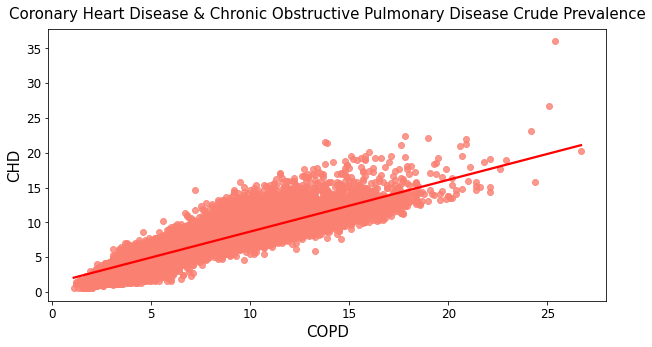

In [227]:
plt.figure(figsize = (10,5))
sns.regplot(x= 'copd', y= 'chd', data= df, color = 'salmon', line_kws = {'color': 'red'})
plt.title('Coronary Heart Disease & Chronic Obstructive Pulmonary Disease Crude Prevalence', size = 15, pad = 10),
plt.xlabel(xlabel = 'COPD', size = 15)
plt.ylabel(ylabel = 'CHD', size = 15);
# plt.savefig('./imgs/chd_COPD.png', dpi = 300, bbox_inches = 'tight')
plt.show()

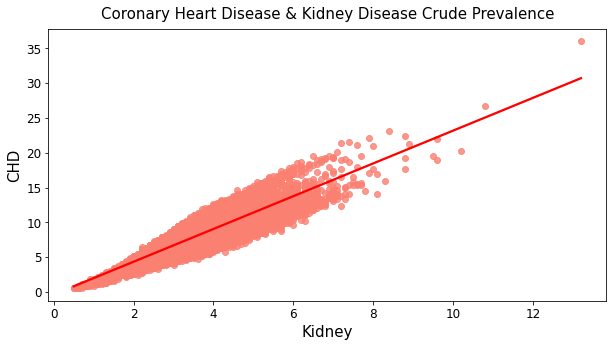

In [228]:
plt.figure(figsize = (10,5))
sns.regplot(x= 'kidney_disease', y= 'chd', data= df, color = 'salmon', line_kws = {'color': 'red'})
plt.title('Coronary Heart Disease & Kidney Disease Crude Prevalence', size = 15, pad = 10),
plt.xlabel(xlabel = 'Kidney', size = 15)
plt.ylabel(ylabel = 'CHD', size = 15);
# plt.savefig('./imgs/chd_kd.png', dpi = 300, bbox_inches = 'tight')
plt.show()

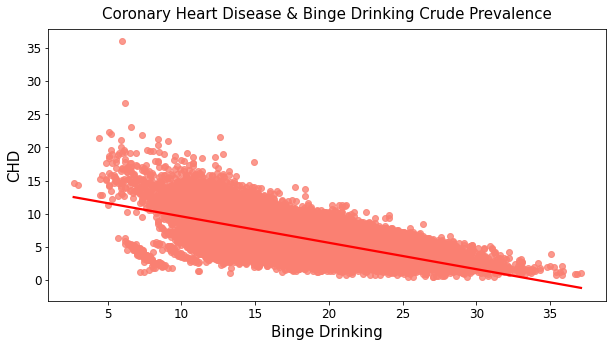

In [229]:
plt.figure(figsize = (10,5))
sns.regplot(x= 'binge_drinking', y= 'chd', data= df, color = 'salmon', line_kws = {'color': 'red'})
plt.title('Coronary Heart Disease & Binge Drinking Crude Prevalence', size = 15, pad = 10),
plt.xlabel(xlabel = 'Binge Drinking', size = 15)
plt.ylabel(ylabel = 'CHD', size = 15);
# plt.savefig('./imgs/chd_binge_drink.png', dpi = 300, bbox_inches = 'tight')
plt.show()

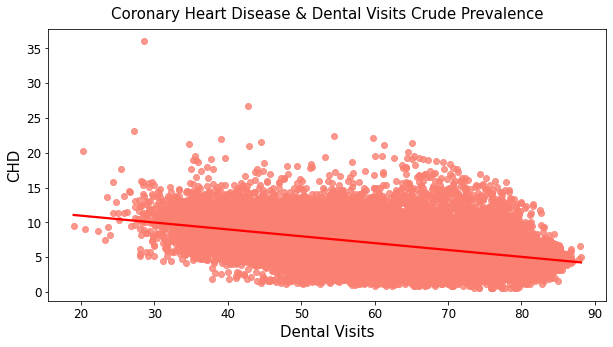

In [230]:
plt.figure(figsize = (10,5))
sns.regplot(x= 'dental_visits', y= 'chd', data= df, color = 'salmon', line_kws = {'color': 'red'})
plt.title('Coronary Heart Disease & Dental Visits Crude Prevalence', size = 15, pad = 10),
plt.xlabel(xlabel = 'Dental Visits', size = 15)
plt.ylabel(ylabel = 'CHD', size = 15);
# plt.savefig('./imgs/chd_dental.png', dpi = 300, bbox_inches = 'tight')
plt.show()

The top two positively correlated values with crude prevalence of coronary heart disease are crude prevalence of chronic obstructive pulmonary disease (0.91) and crude prevalence of kidney disease (0.89). As crude prevalence of chronic obstructive pulmonary disease and/or kidney disease increase, crude prevalence of coronary heart disease increases. <br>

The top two negatively correlated values with crude prevalence of coronary heart disease are crude prevalence of binge drinking (-0.63) and crude prevalence of visits to the dentist or dental clinic (-0.5). As crude prevalence of binge drinking and/or visits to the dentist or dental clinic increase, crude prevalence of coronary heart disease decreases.

# Regression Modeling <span id = 'reg_mod'>

In [231]:
# Copying df for regression modeling
reg = df

In [232]:
X = reg._get_numeric_data().drop(columns = 'chd')
y = reg['chd']

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 321)

### Baseline

In [233]:
y_train_baseline = [y_train.mean()]*len(y_train)
y_test_baseline = [y_train.mean()]*len(y_test)

print(f'Baseline Train RMSE: {metrics.mean_squared_error(y_train,y_train_baseline) ** 0.5}')
print(f'Baseline Test RMSE: {metrics.mean_squared_error(y_test, y_test_baseline) ** 0.5}')

Baseline Train RMSE: 2.19696252491771
Baseline Test RMSE: 2.180286114686622


### Linear Regression

In [234]:
# Checking cross_val_score mean
cross_val_score(LinearRegression(),X_train,y_train, cv = 20, scoring = 'r2').mean()

0.9913593273355904

In [235]:
lr = LinearRegression()
lr.fit(X_train, y_train)

print(f'Linear Reg Train R2: {lr.score(X_train, y_train)}')
print(f'Linear Reg Test R2: {lr.score(X_test, y_test)}')

Linear Reg Train R2: 0.9914051962455878
Linear Reg Test R2: 0.9910159467954724


In [236]:
# Setting Predictions
train_preds = lr.predict(X_train)
test_preds = lr.predict(X_test)

print(f'Linear Reg Train RMSE: {metrics.mean_squared_error(y_train, train_preds, squared=False)}')
print(f'Linear Reg Test RMSE: {metrics.mean_squared_error(y_test, test_preds, squared=False)}')

Linear Reg Train RMSE: 0.20367636303543915
Linear Reg Test RMSE: 0.20665039172679484


### Regression Plot

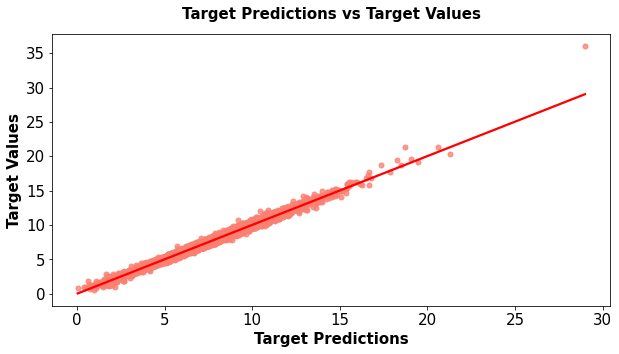

In [237]:
# Regression plot 
plt.figure(figsize = (10,5))
sns.regplot(x = test_preds, y = y_test, ci=None, 
            color = 'salmon',
            scatter_kws = {'s': 25}, 
            line_kws = {'color': 'red'})
plt.xlabel('Target Predictions', size = 15, fontweight = 'bold')
plt.xticks(size = 15)
plt.ylabel('Target Values', size = 15, fontweight = 'bold')
plt.yticks(size = 15)
plt.title('Target Predictions vs Target Values', size = 15, pad = 15, fontweight = 'bold');
# plt.savefig('./imgs/chd_reg_plot.png', dpi = 300, bbox_inches = 'tight')
plt.show()

## Ridge <span id ='ridge'>

In [238]:
# Scale
ss = StandardScaler()
Z_train = ss.fit_transform(X_train)
Z_test = ss.transform(X_test)

In [239]:
ridge_cv = RidgeCV(alphas = np.logspace(0,50,100), scoring = 'r2', cv = 5)
ridge_cv.fit(Z_train, y_train)

print(f'Ridge Train R2: {ridge_cv.score(Z_train, y_train)}')
print(f'Ridge Test R2: {ridge_cv.score(Z_test, y_test)}')

Ridge Train R2: 0.9913895046180725
Ridge Test R2: 0.9910035010325434


In [240]:
# Getting predictions for the RMSE
ridge_train_preds = ridge_cv.predict(Z_train)
ridge_test_preds = ridge_cv.predict(Z_test)

print(f'Ridge Train RMSE: {metrics.mean_squared_error(y_train, ridge_train_preds, squared = False)}')
print(f'Ridge Test RMSE: {metrics.mean_squared_error(y_test, ridge_test_preds, squared = False)}')

Ridge Train RMSE: 0.20386220533588684
Ridge Test RMSE: 0.20679348035342662


### Ridge Plot

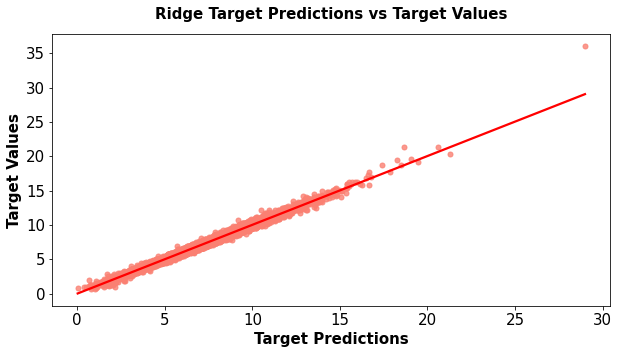

In [241]:
# Ridge plot 
plt.figure(figsize = (10,5))
sns.regplot(x = ridge_test_preds, y = y_test, ci=None, 
            color = 'salmon',
            scatter_kws = {'s': 25}, 
            line_kws = {'color': 'red'})
plt.xlabel('Target Predictions', size = 15, fontweight = 'bold')
plt.xticks(size = 15)
plt.ylabel('Target Values', size = 15, fontweight = 'bold')
plt.yticks(size = 15)
plt.title('Ridge Target Predictions vs Target Values', size = 15, pad = 15, fontweight = 'bold');
# plt.savefig('./imgs/chd_ridge_plot.png', dpi = 300, bbox_inches = 'tight')
plt.show()

## Lasso <span id = 'lasso'>

In [242]:
lasso = LassoCV(cv = 5)
lasso.fit(Z_train, y_train)

print(f'Lasso Train R2: {lasso.score(Z_train, y_train)}')
print(f'Lasso Test R2: {lasso.score(Z_test, y_test)}')

Lasso Train R2: 0.9909698520647636
Lasso Test R2: 0.99057193700822


In [243]:
lasso_train_preds = lasso.predict(Z_train)
lasso_test_preds = lasso.predict(Z_test)

print(f'Lasso Train RMSE: {metrics.mean_squared_error(y_train, lasso_train_preds, squared = False)}')
print(f'Lasso Test RMSE: {metrics.mean_squared_error(y_test, lasso_test_preds, squared = False)}')

Lasso Train RMSE: 0.20877095675376567
Lasso Test RMSE: 0.21169534727490028


### Lasso Plot

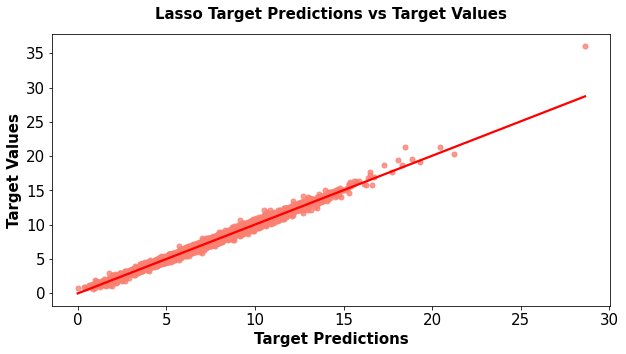

In [244]:
# Lasso plot 
plt.figure(figsize = (10,5))
sns.regplot(x = lasso_test_preds, y = y_test, ci=None, 
            color = 'salmon',
            scatter_kws = {'s': 25}, 
            line_kws = {'color': 'red'})
plt.xlabel('Target Predictions', size = 15, fontweight = 'bold')
plt.xticks(size = 15)
plt.ylabel('Target Values', size = 15, fontweight = 'bold')
plt.yticks(size = 15)
plt.title('Lasso Target Predictions vs Target Values', size = 15, pad = 15, fontweight = 'bold');
# plt.savefig('./imgs/chd_lasso_plot.png', dpi = 300, bbox_inches = 'tight')
plt.show()

## Regression Results <span id ='reg_results'>

In [245]:
reg_dict = {}

reg_dict['Model'] = ['Linear Regression', 'Ridge Regression', 'Lasso Regression']
reg_dict['Train R2'] = [lr.score(X_train, y_train), ridge_cv.score(Z_train, y_train), lasso.score(Z_train, y_train)]
reg_dict['Test R2'] = [lr.score(X_test, y_test), ridge_cv.score(Z_test, y_test), lasso.score(Z_test, y_test)]
reg_dict['Train RMSE'] = [metrics.mean_squared_error(y_train, train_preds, squared = False), metrics.mean_squared_error(y_train, ridge_train_preds, squared = False), metrics.mean_squared_error(y_train, lasso_train_preds, squared = False)]
reg_dict['Test RMSE'] = [metrics.mean_squared_error(y_test, test_preds, squared = False), metrics.mean_squared_error(y_test, ridge_test_preds, squared = False), metrics.mean_squared_error(y_test, lasso_test_preds, squared = False)]

reg_df = pd.DataFrame.from_dict(reg_dict, orient = 'columns')

reg_df

,Model,Train R2,Test R2,Train RMSE,Test RMSE
0,Linear Regression,0.991405,0.991016,0.203676,0.206650
1,Ridge Regression,0.991390,0.991004,0.203862,0.206793
2,Lasso Regression,0.990970,0.990572,0.208771,0.211695


Our Linear Regression model is performing the best out of these three models with a Train R-squared score of .9914 and Test R-squared score of 0.9910. This is over 99% that our baseline model with no predictors. 

The Linear Regression model has the lowest RMSE scores, with a Train RMSE of 0.2036 and Test RMSE of 0.2066. These are almost 2.0 better than our baseline model.

# Classification <span id = 'classification'>

<span id = 'cclean'></span>
### Cleaning

In [246]:
# Creating list as reference for low & intermediate to high risk chd 
chd = []

for i in df['chd']:
    if i < 10: 
        chd.append(0)  # Low
    elif i >= 10: 
        chd.append(1)  # Intermediate to High

df['chd'] = chd

In [247]:
df.shape

(72094, 83)

In [248]:
df[df['chd'] == 0].shape

(66716, 83)

In [249]:
# Seeing how many rows are not 0
72094-66716

5378

In [250]:
# Seeing how many rows need to be dropped from 0
66716 - 5378

61338

In [251]:
# Randomly dropping 61338 rows to have 5378 0s and 1s 
np.random.seed(321)
remove = 61338
remove_0 = df.loc[(df['chd']==0)]
drop = np.random.choice(remove_0.index, remove, replace = False)

# Inspired from https://stackoverflow.com/questions/28556942/pandas-remove-rows-at-random-without-shuffling-dataset

In [252]:
chd = df.drop(drop)

chd['chd'].value_counts()

1    5378
0    5378
Name: chd, dtype: int64

In [253]:
corr = chd.corr()[['chd']]
corr = corr.loc[(corr['chd'] > .6) | (corr['chd'] < -0.35)]

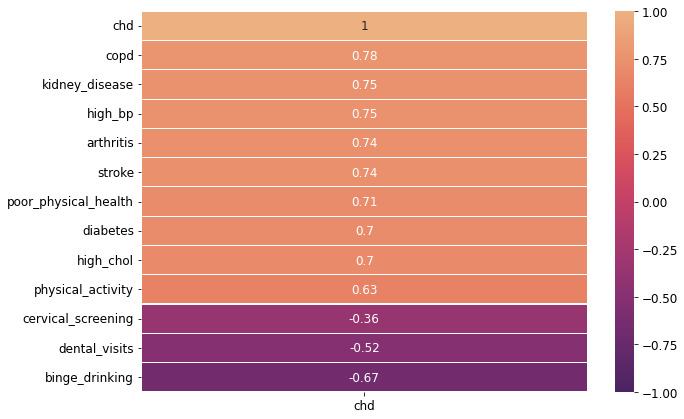

In [254]:
plt.figure(figsize = (10,7))
sns.heatmap(data = corr.sort_values(by = 'chd', ascending = False), annot = True, vmin=-1, 
            vmax=1, cmap = 'flare_r', linewidths=0.05);
# plt.savefig('./imgs/chd_class_corr.png', dpi = 300, bbox_inches = 'tight')
plt.show()

The top two positively correlated values with crude prevalence of coronary heart disease are crude prevalence of chronic obstructive pulmonary disease (0.78) and crude prevalence of kidney disease (0.75). As crude prevalence of chronic obstructive pulmonary disease and/or kidney disease increase, crude prevalence of coronary heart disease increases. <br>

The top two negatively correlated values with crude prevalence of coronary heart disease are crude prevalence of binge drinking (-0.67) and crude prevalence of visits to the dentist or dental clinic (-0.52). As crude prevalence of binge drinking and/or visits to the dentist or dental clinic increase, crude prevalence of coronary heart disease decreases.

## Modeling <span id= 'cmodel'>

In [255]:
X = chd._get_numeric_data().drop(columns = 'chd')
y = chd['chd']

X_train, X_test, y_train, y_test = train_test_split(X,y, stratify = y, random_state = 321)

### Baseline

In [256]:
y_train.value_counts(normalize = True)

1    0.500062
0    0.499938
Name: chd, dtype: float64

In [257]:
# Scale Data
ss = StandardScaler()
Z_train = ss.fit_transform(X_train)
Z_test = ss.transform(X_test)

## Logistic Regression <span id = 'logreg'>

In [258]:
# Getting cross_val_score
cross_val_score(LogisticRegression(max_iter=1000), Z_train, y_train, cv = 5).mean()

0.9832653832591605

In [259]:
logreg = LogisticRegression(C = 1, penalty = 'l2', solver = 'liblinear')
logreg.fit(Z_train, y_train)

print(f'LogReg Train Accuracy: {logreg.score(Z_train, y_train)}')
print(f'LogReg Test Accuracy: {logreg.score(Z_test, y_test)}')

LogReg Train Accuracy: 0.98723193256477
LogReg Test Accuracy: 0.9851245816288583


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


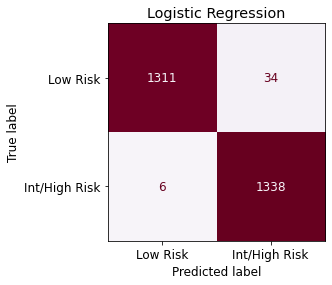

In [260]:
preds_logreg = logreg.predict(Z_test)

tn, fp, fn, tp = metrics.confusion_matrix(y_test, preds_logreg).ravel()
plt.rcParams.update({'font.size': 12}) 
metrics.plot_confusion_matrix(logreg, Z_test, y_test, cmap = 'PuRd',colorbar = False, display_labels = ['Low Risk','Int/High Risk']);
plt.title('Logistic Regression');
# plt.savefig('./imgs/chd_conf_logreg.png', dpi = 300, bbox_inches = 'tight')
plt.show()

In [261]:
print(f'Precision Rate: {metrics.precision_score(y_test, preds_logreg)}')
print(f'Specificity Rate: {(tn / (tn + fp))}')
print(f'Recall Rate: {metrics.recall_score(y_test, preds_logreg)}')
print(f'Misclassification: {1 - (logreg.score(Z_test, y_test))}')
print(f'F1 Score: {metrics.f1_score(y_test,preds_logreg)}')

Precision Rate: 0.9752186588921283
Specificity Rate: 0.9747211895910781
Recall Rate: 0.9955357142857143
Misclassification: 0.014875418371141702
F1 Score: 0.9852724594992637


In [262]:
logreg_spec = (tn / (tn + fp))
logreg_misc = (1 - (logreg.score(Z_test, y_test)))

## KNN <span id = 'knn'>

In [263]:
cross_val_score(KNeighborsClassifier(n_neighbors=3), Z_train, y_train, cv = 5).mean()

0.952770742057831

In [264]:
# Getting cross_val_score
kn = KNeighborsClassifier(n_neighbors = 3)
kn.fit(Z_train, y_train)

print(f'KNN Train Accuracy: {kn.score(Z_train, y_train)}')
print(f'KNN Test Accuracy: {kn.score(Z_test, y_test)}')

KNN Train Accuracy: 0.9766951778852113
KNN Test Accuracy: 0.9531424321309037


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


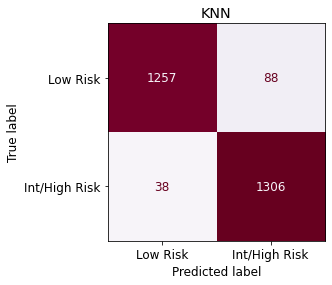

In [265]:
preds_kn = kn.predict(Z_test)

tn, fp, fn, tp = metrics.confusion_matrix(y_test, preds_kn).ravel()
plt.rcParams.update({'font.size': 12}) 
metrics.plot_confusion_matrix(kn, Z_test, y_test, cmap = 'PuRd',colorbar = False, display_labels = ['Low Risk','Int/High Risk']);
plt.title('KNN');
# plt.savefig('./imgs/chd_conf_knn.png', dpi = 300, bbox_inches = 'tight')
plt.show()

In [266]:
print(f'Precision Rate: {metrics.precision_score(y_test, preds_kn)}')
print(f'Specificity Rate: {(tn / (tn + fp))}')
print(f'Recall Rate: {metrics.recall_score(y_test, preds_kn)}')
print(f'Misclassification: {1 - (kn.score(Z_test, y_test))}')
print(f'F1 Score: {metrics.f1_score(y_test,preds_kn)}')

Precision Rate: 0.9368723098995696
Specificity Rate: 0.9345724907063196
Recall Rate: 0.9717261904761905
Misclassification: 0.04685756786909634
F1 Score: 0.9539810080350621


In [267]:
kn_spec = (tn / (tn + fp))
kn_misc = (1 - (kn.score(Z_test, y_test)))

## BNB <span id = 'bnb'>

In [268]:
# Getting cross_val_score
cross_val_score(BernoulliNB(), Z_train, y_train, cv = 5).mean()

0.9095084009953206

In [269]:
bnb = BernoulliNB()
bnb.fit(Z_train, y_train)

print(f'BernoulliNB Train Accuracy: {bnb.score(Z_train, y_train)}')
print(f'BernoulliNB Test Accuracy Logreg: {bnb.score(Z_test, y_test)}')

BernoulliNB Train Accuracy: 0.9097557952150738
BernoulliNB Test Accuracy Logreg: 0.9077724060989215


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


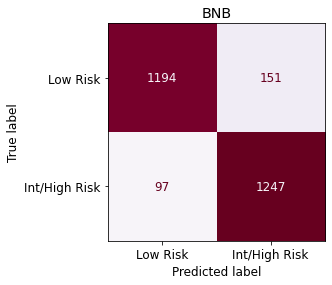

In [270]:
preds_bnb = bnb.predict(Z_test)

tn, fp, fn, tp = metrics.confusion_matrix(y_test, preds_bnb).ravel()
plt.rcParams.update({'font.size': 12}) 
metrics.plot_confusion_matrix(bnb, Z_test, y_test, cmap = 'PuRd',colorbar = False, display_labels = ['Low Risk','Int/High Risk']);
plt.title('BNB');
# plt.savefig('./imgs/chd_conf_bnb.png', dpi = 300, bbox_inches = 'tight')
plt.show()

In [271]:
print(f'Precision Rate: {metrics.precision_score(y_test, preds_bnb)}')
print(f'Specificity Rate: {(tn / (tn + fp))}')
print(f'Recall Rate: {metrics.recall_score(y_test, preds_bnb)}')
print(f'Misclassification: {1 - (bnb.score(Z_test, y_test))}')
print(f'F1 Score: {metrics.f1_score(y_test,preds_bnb)}')

Precision Rate: 0.8919885550786838
Specificity Rate: 0.8877323420074349
Recall Rate: 0.9278273809523809
Misclassification: 0.09222759390107849
F1 Score: 0.9095550692924872


In [272]:
bnb_spec = (tn / (tn + fp))
bnb_misc = (1 - (bnb.score(Z_test, y_test)))

## Classification Results <span id = 'class_con'>

In [273]:
class_dict = {}

class_dict['Model'] = ['Logistic Regression', 'KNN', 'BernoulliNB']
class_dict['Train Accuracy'] = [logreg.score(Z_train, y_train), kn.score(Z_train, y_train), bnb.score(Z_train, y_train)]
class_dict['Test Accuracy'] = [logreg.score(Z_test, y_test), kn.score(Z_test, y_test), bnb.score(Z_test, y_test)]
class_dict['Recall'] = [metrics.recall_score(y_test, preds_logreg), metrics.recall_score(y_test, preds_kn), metrics.recall_score(y_test, preds_bnb)]
class_dict['Precision'] = [metrics.precision_score(y_test, preds_logreg), metrics.precision_score(y_test, preds_kn), metrics.precision_score(y_test, preds_bnb)]
class_dict['F1'] = [metrics.f1_score(y_test, preds_logreg),metrics.f1_score(y_test, preds_kn), metrics.f1_score(y_test, preds_bnb)]
class_dict['Misclassification'] = [logreg_misc, kn_misc, bnb_misc]
class_dict['Specificity'] = [logreg_spec, kn_spec, bnb_spec]

class_df = pd.DataFrame.from_dict(class_dict, orient = 'columns')

class_df

,Model,Train Accuracy,Test Accuracy,Recall,Precision,F1,Misclassification,Specificity
0,Logistic Regression,0.987232,0.985125,0.995536,0.975219,0.985272,0.014875,0.974721
1,KNN,0.976695,0.953142,0.971726,0.936872,0.953981,0.046858,0.934572
2,BernoulliNB,0.909756,0.907772,0.927827,0.891989,0.909555,0.092228,0.887732


Our Logistic Regression model is performing the best overall with a 0.987 train accuracy and 0.985 test accuracy. We have high recall and precision scores, indicating we were reasonably successful in predicting false positives and false negatives. We misclassified approximately 1.5% of the risk ratings. We were more successful in predicting false negatives vs. false positives, but are performing reasonably well overall. 

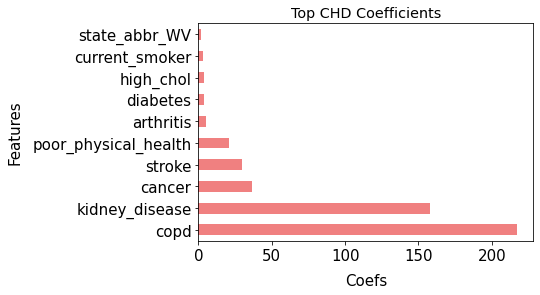

In [274]:
logreg_coefs = (pd.DataFrame(np.exp(logreg.coef_), columns = X.columns).T)
logreg_coefs.sort_values(by = 0, axis = 0, ascending = False)[:10].plot(kind = 'barh', legend = False, title='Top CHD Coefficients', 
                                                                         color = 'lightcoral')
plt.ylabel('Features', fontsize = 15, labelpad = 10)
plt.yticks(size = 15)
plt.xlabel('Coefs', fontsize = 15, labelpad = 10)
plt.xticks(size = 15);
# plt.savefig('./imgs/coefs_chd.png',dpi=300, bbox_inches = "tight")

In [275]:
np.exp(logreg_coefs.sort_values(by = 0, axis = 0, ascending = False).head(10))

,0
copd,2.756850e+94
kidney_disease,4.980198e+68
cancer,6.347168e+15
stroke,7.082277e+12
poor_physical_health,8.053135e+08
arthritis,2.057047e+02
diabetes,4.099395e+01
high_chol,3.351518e+01
current_smoker,2.009989e+01
state_abbr_WV,7.616267e+00


In [276]:
np.exp(logreg_coefs.sort_values(by = 0, axis = 0, ascending = False).tail(10))

,0
state_abbr_IL,1.806083
high_bp,1.768052
state_abbr_CA,1.709805
teeth_lost,1.546221
poor_sleep,1.434198
chol_screen,1.422283
doc_checkups,1.329660
cervical_screening,1.307149
mental_health,1.122229
current_asthma,1.062224


<span id = 'class_con'></span>
**States:** 

- If a person lives in the state of West Virginia, we would expect the crude prevalence of coronary heart disease to increase by 0.707789 compared to someone living in Washington DC, all else being constant. 
- If a person lives in the state of Kentucky, we would expect the crude prevalence of coronary heart disease to increase by 0.619679 compared to someone living in Washington DC, all else being constant. 
<br>
<br>
- If a person lives in the state of California, we would expect the crude prevalence of coronary heart disease to decrease by -0.621134 compared to someone living in Washington DC, all else being constant. 
- If a person lives in the state of Illinois, we would expect the crude prevalence of coronary heart disease to decrease by -0.526609 compared to someone living in Washington DC, all else being constant. 

**Crude Prevalence:**
- For every 1 unit increase in the crude prevalence of chronic obstructive pulmonary disease, we would expect the crude prevalence of coronary heart disease to increase by 216.035 times, all else being constant.
- For every 1 unit increase in the crude prevalence of kidney disease, we would expect the crude prevalence of coronary heart disease to increase by 157.837 times, all else being constant.
- For every 1 unit increase in the crude prevalence of cancer, we would expect the crude prevalence of coronary heart disease to increase by 36.491, all else being constant.

**Similar Features to Cleveland Hungary Dataset:**
- For every 1 unit increase in crude prevalence of poor physical health, we would expect the crude prevalence of coronary heart disease to increase by 3.019379, all else being constant.
- For every 1 unit increase in crude prevalence of high cholesterol, we would expect the crude prevalence of coronary heart disease to increase by 1.257013, all else being constant.
- For every 1 unit increase in crude prevalence of high blood pressure, we would expect the crude prevalence of coronary heart disease to decrease by -0.561533, all else being constant.

<span id = 'chdc'></span>
## Conclusions
Through our CHD evaluation, we would expect that the crude prevalence of kidney disease, chronic obstructive pulmonary disease, and/or cancer would increase the risk of an individual's crude prevalence of coronary heart disease.

  Washington D.C. had the lowest average crude prevalence risk rate for coronary heart disease amongst all states in the U.S. We used Washington D.C. as our reference column when evaluating the average risk rates in other states. We expect the crude prevalence of coronary heart disease to increase by .707789 for a person living in the state of West Virginia, and the crude prevalence of heart disease to increase by 0.619679 for a person living in the state of Kentucky compared to someone living in Washington D.C, all else being constant.

  By evaluating similar features to the CVD dataset, we concluded that for every 1 unit increase in crude prevalence of poor physical health, we would expect the crude prevalence of coronary heart disease to increase by 3.019379, for every 1 unit increase in crude prevalence of high cholesterol, we would expect the crude prevalence of coronary heart disease to increase by 1.257013, and for every 1 unit increase in crude prevalence of high blood pressure, we would expect the crude prevalence of coronary heart disease to decrease by -0.561533, all else being constant.

<span id = 'nxtsteps'></span>
# Next Steps
  In future iterations of our model, we would like to train our model on more diverse populations. Our current data set(s) primarily focus on populations in high-income countries, but ideally, we would like our results to be generalizable to a larger population. Therefore, collecting data on more diverse populations, specifically on age, sex, socio-economic status, race, and location, would help us build a build that can generalize to more people. Having more data (more diverse data or simply data in general) would be the best way to improve our model and its predictive ability.

  We would also look at collecting data for a larger sample size, as our CVD dataset represented 1190 people.

  We would also recommend collecting data on other subsets of CVD to gather more information on other potential risk factors that may not have been in our scope. Subsets may include Cerebrovascular Disease, Peripheral Arterial Disease, Rheumatic Heart Disease, Congenital Heart Disease.

  After collecting supplementary data, we would need to train our model and fine-tune the hyperparameters. After the model has been trained, we would recommend deploying the model with the best performance for beta testing in hospitals or other health care facilities.